# Sequential Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [3]:
import gym

# Create the Cart-Pole game environment
#env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
for _ in range(10):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

state, action, reward, done, info: [ 0.03367204 -0.18377751 -0.02637949  0.27589704] 0 1.0 False {}
state, action, reward, done, info: [ 0.02999649  0.01171068 -0.02086155 -0.02498789] 1 1.0 False {}
state, action, reward, done, info: [ 0.0302307   0.20712549 -0.0213613  -0.32417918] 1 1.0 False {}
state, action, reward, done, info: [ 0.03437321  0.01231411 -0.02784489 -0.03830853] 0 1.0 False {}
state, action, reward, done, info: [ 0.03461949  0.20782406 -0.02861106 -0.33964511] 1 1.0 False {}
state, action, reward, done, info: [ 0.03877597  0.40334119 -0.03540396 -0.64121127] 1 1.0 False {}
state, action, reward, done, info: [ 0.0468428   0.59893833 -0.04822819 -0.94482972] 1 1.0 False {}
state, action, reward, done, info: [ 0.05882157  0.7946756  -0.06712478 -1.25226782] 1 1.0 False {}
state, action, reward, done, info: [ 0.07471508  0.99059021 -0.09217014 -1.56519781] 1 1.0 False {}
state, action, reward, done, info: [ 0.09452688  1.18668501 -0.12347409 -1.88515114] 1 1.0 False {}


To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
# print(rewards[-20:])
# print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
# print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
# print(np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
# print(np.max(np.array(rewards)), np.min(np.array(rewards)))
# print(np.max(np.array(states)), np.min(np.array(states)))

The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [132]:
def model_input(state_size, lstm_size, batch_size=1):
    actions = tf.placeholder(tf.int32, [None], name='actions')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
        
    gru = tf.nn.rnn_cell.GRUCell(lstm_size)
    cell = tf.nn.rnn_cell.MultiRNNCell([gru], state_is_tuple=False)
    initial_state = cell.zero_state(batch_size, tf.float32)
    
    return actions, states, targetQs, cell, initial_state

In [133]:
# RNN generator or sequence generator
def generator(states, initial_state, cell, lstm_size, num_classes, reuse=False): 
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        inputs = tf.layers.dense(inputs=states, units=lstm_size)
        print(states.shape, inputs.shape)
        
        # with tf.variable_scope('dynamic_rnn_', reuse=tf.AUTO_REUSE):
        # dynamic means adapt to the batch_size
        inputs_rnn = tf.reshape(inputs, [1, -1, lstm_size]) # NxH -> 1xNxH
        print(inputs_rnn.shape, initial_state.shape)
        outputs_rnn, final_state = tf.nn.dynamic_rnn(cell=cell, inputs=inputs_rnn, initial_state=initial_state)
        print(outputs_rnn.shape, final_state.shape)
        outputs = tf.reshape(outputs_rnn, [-1, lstm_size]) # 1xNxH -> NxH
        print(outputs.shape)

        # Last fully connected layer
        logits = tf.layers.dense(inputs=outputs, units=num_classes)
        print(logits.shape)
        #predictions = tf.nn.softmax(logits)
        
        # logits are the action logits
        return logits, final_state

In [134]:
def model_outputs(action_size, hidden_size, states, cell, initial_state):
    actions_logits, final_state = generator(states=states, cell=cell, initial_state=initial_state, 
                                            lstm_size=hidden_size, num_classes=action_size)
    return actions_logits, final_state

In [142]:
def model_loss(action_size, hidden_size, states, cell, initial_state, actions, targetQs):
    actions_logits, _ = generator(states=states, cell=cell, initial_state=initial_state, 
                                  lstm_size=hidden_size, num_classes=action_size, reuse=True)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs = tf.reduce_max(actions_logits*actions_labels, axis=1)
    loss = tf.reduce_mean(tf.square(Qs - targetQs))
#     loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits, 
#                                                                   labels=tf.nn.sigmoid(targetQs[1:])))
    return actions_logits, loss

In [143]:
def model_opt(loss, learning_rate):
    """
    Get optimization operations in order
    :param loss: Generator loss Tensor for action prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # # Optimize
    # with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
    # #opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    #grads, _ = tf.clip_by_global_norm(t_list=tf.gradients(loss, g_vars), clip_norm=5) # usually around 1-5
    grads = tf.gradients(loss, g_vars)
    opt = tf.train.AdamOptimizer(learning_rate).apply_gradients(grads_and_vars=zip(grads, g_vars))

    return opt

In [144]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.actions, self.states, self.targetQs, cell, self.initial_state = model_input(
            state_size=state_size, lstm_size=hidden_size)
        
        # Output of the Model: calculating the loss and forwad pass
        self.actions_logits, self.final_state = model_outputs(
            action_size=action_size, hidden_size=hidden_size, 
            states=self.states, cell=cell, initial_state=self.initial_state)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, 
            states=self.states, actions=self.actions, targetQs=self.targetQs, 
            cell=cell, initial_state=self.initial_state)

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [145]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
        self.states = deque(maxlen=max_size)

In [157]:
# episode_total_reward = deque(maxlen=10)

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [158]:
# print('state:', np.array(states).shape[1], 
#       'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

In [166]:
# Training parameters
batch_size = 32                # number of samples in the memory/ experience as mini-batch size
learning_rate = 0.001          # learning rate for adam

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
action_size = 2                # number of units for the output actions -- simulation

In [167]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=batch_size)

(?, 4) (?, 64)
(1, ?, 64) (1, 64)
(1, ?, 64) (1, 64)
(?, 64)
(?, 2)
(?, 4) (?, 64)
(1, ?, 64) (1, 64)
(1, ?, 64) (1, 64)
(?, 64)
(?, 2)


## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [168]:
state = env.reset()
for _ in range(batch_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    state = next_state
    if done is True:
        state = env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [169]:
memory.buffer[0]

[array([ 0.03912216,  0.01218385, -0.00347782,  0.04461972]),
 1,
 array([ 0.03936583,  0.2073555 , -0.00258543, -0.24915846]),
 1.0,
 0.0]

In [170]:
# states, rewards, actions

In [185]:
# Now train with experiences
saver = tf.train.Saver() # save the trained model
rewards_list, loss_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    initial_state = sess.run(model.initial_state) # Qs or current batch or states[:-1]
    total_step = 0 # Explore or exploit parameter
    episode_loss = deque(maxlen=batch_size)
    episode_reward = deque(maxlen=batch_size)
    
    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0
        loss_batch = []
        state = env.reset()

        # Training steps/batches
        while True:
            action_logits, final_state = sess.run([model.actions_logits, model.final_state],
                                                  feed_dict = {model.states: state.reshape([1, -1]), 
                                                               model.initial_state: initial_state})
            
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.states.append([initial_state, final_state])
            total_reward += reward
            initial_state = final_state
            state = next_state

            # Training
            batch = memory.buffer
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            rnn_states = memory.states
            initial_states = np.array([each[0] for each in rnn_states])
            final_states = np.array([each[1] for each in rnn_states])
            actions_logits = sess.run(model.actions_logits, 
                                      feed_dict = {model.states: next_states, 
                                                   model.initial_state: final_states[0].reshape([1, -1])})
            nextQs = np.max(actions_logits, axis=1) * (1-dones)
            targetQs = rewards + (0.99 * nextQs)
            loss, _ = sess.run([model.loss, model.opt], 
                               feed_dict = {model.states: states, 
                                            model.actions: actions,
                                            model.targetQs: targetQs,
                                            model.initial_state: initial_states[0].reshape([1, -1])})
            loss_batch.append(loss)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode: {}'.format(ep),
              'meanReward: {:.4f}'.format(np.mean(episode_reward)),
              'meanLoss: {:.4f}'.format(np.mean(loss_batch)),
              'ExploreP: {:.4f}'.format(explore_p))
        rewards_list.append([ep, np.mean(episode_reward)])
        loss_list.append([ep, np.mean(loss_batch)])
        if(np.mean(episode_reward) >= 500):
            break
    
    saver.save(sess, 'checkpoints/model.ckpt')

Episode: 0 meanReward: 13.0000 meanLoss: 1.4376 ExploreP: 0.9987
Episode: 1 meanReward: 13.0000 meanLoss: 2.0859 ExploreP: 0.9974
Episode: 2 meanReward: 12.3333 meanLoss: 1.8955 ExploreP: 0.9963
Episode: 3 meanReward: 13.7500 meanLoss: 7.2121 ExploreP: 0.9946
Episode: 4 meanReward: 15.6000 meanLoss: 10.4739 ExploreP: 0.9923
Episode: 5 meanReward: 16.6667 meanLoss: 7.0556 ExploreP: 0.9901
Episode: 6 meanReward: 22.1429 meanLoss: 2.2025 ExploreP: 0.9848
Episode: 7 meanReward: 26.7500 meanLoss: 4.1586 ExploreP: 0.9790
Episode: 8 meanReward: 25.3333 meanLoss: 9.7931 ExploreP: 0.9777
Episode: 9 meanReward: 24.7000 meanLoss: 17.9609 ExploreP: 0.9758
Episode: 10 meanReward: 25.0000 meanLoss: 15.0360 ExploreP: 0.9731
Episode: 11 meanReward: 24.5000 meanLoss: 16.6036 ExploreP: 0.9713
Episode: 12 meanReward: 24.3077 meanLoss: 19.1308 ExploreP: 0.9692
Episode: 13 meanReward: 25.9286 meanLoss: 13.1408 ExploreP: 0.9647
Episode: 14 meanReward: 25.3333 meanLoss: 17.2051 ExploreP: 0.9631
Episode: 15 m

Episode: 123 meanReward: 27.9375 meanLoss: 1.6444 ExploreP: 0.7266
Episode: 124 meanReward: 31.0000 meanLoss: 1.0872 ExploreP: 0.7186
Episode: 125 meanReward: 32.0312 meanLoss: 29.3952 ExploreP: 0.7149
Episode: 126 meanReward: 32.3438 meanLoss: 41.7736 ExploreP: 0.7125
Episode: 127 meanReward: 31.8438 meanLoss: 8.8394 ExploreP: 0.7108
Episode: 128 meanReward: 32.2500 meanLoss: 49.0338 ExploreP: 0.7091
Episode: 129 meanReward: 34.8125 meanLoss: 22.9686 ExploreP: 0.7026
Episode: 130 meanReward: 34.8750 meanLoss: 17.2163 ExploreP: 0.7011
Episode: 131 meanReward: 34.8750 meanLoss: 34.7936 ExploreP: 0.7001
Episode: 132 meanReward: 34.7812 meanLoss: 8.3001 ExploreP: 0.6992
Episode: 133 meanReward: 34.9688 meanLoss: 9.1053 ExploreP: 0.6979
Episode: 134 meanReward: 35.6562 meanLoss: 55.0049 ExploreP: 0.6953
Episode: 135 meanReward: 35.1250 meanLoss: 11.4377 ExploreP: 0.6942
Episode: 136 meanReward: 34.1562 meanLoss: 8.8163 ExploreP: 0.6930
Episode: 137 meanReward: 34.5312 meanLoss: 12.8247 Exp

Episode: 244 meanReward: 53.8438 meanLoss: 95.8031 ExploreP: 0.4702
Episode: 245 meanReward: 54.6250 meanLoss: 17.1217 ExploreP: 0.4682
Episode: 246 meanReward: 54.7500 meanLoss: 99.3669 ExploreP: 0.4670
Episode: 247 meanReward: 56.8438 meanLoss: 32.1049 ExploreP: 0.4630
Episode: 248 meanReward: 57.6562 meanLoss: 10.5373 ExploreP: 0.4611
Episode: 249 meanReward: 57.9062 meanLoss: 21.3735 ExploreP: 0.4598
Episode: 250 meanReward: 58.2500 meanLoss: 112.7230 ExploreP: 0.4586
Episode: 251 meanReward: 59.5938 meanLoss: 39.6320 ExploreP: 0.4558
Episode: 252 meanReward: 63.4062 meanLoss: 645.6880 ExploreP: 0.4498
Episode: 253 meanReward: 66.0312 meanLoss: 1016.1744 ExploreP: 0.4453
Episode: 254 meanReward: 69.3750 meanLoss: 125.1309 ExploreP: 0.4397
Episode: 255 meanReward: 76.4062 meanLoss: 848.2800 ExploreP: 0.4291
Episode: 256 meanReward: 79.2188 meanLoss: 506.2054 ExploreP: 0.4244
Episode: 257 meanReward: 79.2188 meanLoss: 109.9089 ExploreP: 0.4190
Episode: 258 meanReward: 79.0625 meanLos

Episode: 364 meanReward: 36.6562 meanLoss: 50.9958 ExploreP: 0.1423
Episode: 365 meanReward: 23.9062 meanLoss: 30.4880 ExploreP: 0.1411
Episode: 366 meanReward: 23.9375 meanLoss: 47.5651 ExploreP: 0.1410
Episode: 367 meanReward: 23.7812 meanLoss: 80.0348 ExploreP: 0.1409
Episode: 368 meanReward: 23.8438 meanLoss: 79.0256 ExploreP: 0.1407
Episode: 369 meanReward: 23.8750 meanLoss: 173.2134 ExploreP: 0.1406
Episode: 370 meanReward: 28.7812 meanLoss: 24.6810 ExploreP: 0.1384
Episode: 371 meanReward: 32.5312 meanLoss: 36.1436 ExploreP: 0.1368
Episode: 372 meanReward: 33.1250 meanLoss: 183.8340 ExploreP: 0.1364
Episode: 373 meanReward: 36.0938 meanLoss: 47.9671 ExploreP: 0.1350
Episode: 374 meanReward: 36.9062 meanLoss: 28.8908 ExploreP: 0.1325
Episode: 375 meanReward: 40.6562 meanLoss: 19.5001 ExploreP: 0.1307
Episode: 376 meanReward: 42.0938 meanLoss: 40.7214 ExploreP: 0.1299
Episode: 377 meanReward: 42.4062 meanLoss: 165.8188 ExploreP: 0.1295
Episode: 378 meanReward: 45.0312 meanLoss: 34

Episode: 484 meanReward: 122.6875 meanLoss: 11.9570 ExploreP: 0.0338
Episode: 485 meanReward: 123.0000 meanLoss: 206.1926 ExploreP: 0.0338
Episode: 486 meanReward: 122.7500 meanLoss: 325.6977 ExploreP: 0.0337
Episode: 487 meanReward: 122.3750 meanLoss: 151.1148 ExploreP: 0.0337
Episode: 488 meanReward: 107.0625 meanLoss: 99.9217 ExploreP: 0.0337
Episode: 489 meanReward: 106.5625 meanLoss: 21.5002 ExploreP: 0.0332
Episode: 490 meanReward: 92.5000 meanLoss: 89.5140 ExploreP: 0.0332
Episode: 491 meanReward: 100.8438 meanLoss: 5.2977 ExploreP: 0.0320
Episode: 492 meanReward: 116.0938 meanLoss: 15.7279 ExploreP: 0.0310
Episode: 493 meanReward: 120.3438 meanLoss: 51.5393 ExploreP: 0.0306
Episode: 494 meanReward: 120.5312 meanLoss: 113.8769 ExploreP: 0.0306
Episode: 495 meanReward: 120.9062 meanLoss: 159.2715 ExploreP: 0.0306
Episode: 496 meanReward: 136.2188 meanLoss: 7.7270 ExploreP: 0.0296
Episode: 497 meanReward: 150.0938 meanLoss: 14.8125 ExploreP: 0.0286
Episode: 498 meanReward: 148.843

Episode: 603 meanReward: 17.2500 meanLoss: 30.0164 ExploreP: 0.0148
Episode: 604 meanReward: 16.5625 meanLoss: 23.5237 ExploreP: 0.0148
Episode: 605 meanReward: 16.0938 meanLoss: 19.3239 ExploreP: 0.0148
Episode: 606 meanReward: 15.5625 meanLoss: 18.6169 ExploreP: 0.0148
Episode: 607 meanReward: 15.2500 meanLoss: 17.9241 ExploreP: 0.0148
Episode: 608 meanReward: 15.0938 meanLoss: 15.8434 ExploreP: 0.0148
Episode: 609 meanReward: 14.4688 meanLoss: 18.0989 ExploreP: 0.0148
Episode: 610 meanReward: 14.2500 meanLoss: 19.4276 ExploreP: 0.0148
Episode: 611 meanReward: 14.4062 meanLoss: 13.8388 ExploreP: 0.0147
Episode: 612 meanReward: 14.3438 meanLoss: 11.1489 ExploreP: 0.0147
Episode: 613 meanReward: 14.3750 meanLoss: 11.4575 ExploreP: 0.0147
Episode: 614 meanReward: 14.5625 meanLoss: 14.5796 ExploreP: 0.0147
Episode: 615 meanReward: 14.7812 meanLoss: 10.6013 ExploreP: 0.0147
Episode: 616 meanReward: 14.6250 meanLoss: 9.3077 ExploreP: 0.0147
Episode: 617 meanReward: 14.4375 meanLoss: 11.567

Episode: 724 meanReward: 159.2812 meanLoss: 35.6712 ExploreP: 0.0112
Episode: 725 meanReward: 168.0625 meanLoss: 3.9992 ExploreP: 0.0111
Episode: 726 meanReward: 165.7188 meanLoss: 40.8168 ExploreP: 0.0111
Episode: 727 meanReward: 177.0312 meanLoss: 4.1344 ExploreP: 0.0110
Episode: 728 meanReward: 177.4375 meanLoss: 27.5279 ExploreP: 0.0110
Episode: 729 meanReward: 173.1875 meanLoss: 24.2169 ExploreP: 0.0110
Episode: 730 meanReward: 159.5625 meanLoss: 122.0836 ExploreP: 0.0110
Episode: 731 meanReward: 163.0938 meanLoss: 5.3577 ExploreP: 0.0110
Episode: 732 meanReward: 163.2812 meanLoss: 3.5981 ExploreP: 0.0110
Episode: 733 meanReward: 172.0000 meanLoss: 11.7272 ExploreP: 0.0109
Episode: 734 meanReward: 169.4375 meanLoss: 142.3718 ExploreP: 0.0109
Episode: 735 meanReward: 168.7812 meanLoss: 20.8057 ExploreP: 0.0109
Episode: 736 meanReward: 178.1562 meanLoss: 14.5222 ExploreP: 0.0109
Episode: 737 meanReward: 187.2188 meanLoss: 8.1737 ExploreP: 0.0108
Episode: 738 meanReward: 197.9375 mea

Episode: 844 meanReward: 353.7188 meanLoss: 227.4338 ExploreP: 0.0101
Episode: 845 meanReward: 338.7812 meanLoss: 163.6609 ExploreP: 0.0101
Episode: 846 meanReward: 323.5625 meanLoss: 61.6105 ExploreP: 0.0101
Episode: 847 meanReward: 316.1562 meanLoss: 9.2434 ExploreP: 0.0101
Episode: 848 meanReward: 301.7500 meanLoss: 62.1893 ExploreP: 0.0101
Episode: 849 meanReward: 287.8125 meanLoss: 60.1945 ExploreP: 0.0101
Episode: 850 meanReward: 272.5625 meanLoss: 39.6456 ExploreP: 0.0101
Episode: 851 meanReward: 263.4375 meanLoss: 114.0973 ExploreP: 0.0101
Episode: 852 meanReward: 275.1250 meanLoss: 29.8148 ExploreP: 0.0101
Episode: 853 meanReward: 269.7812 meanLoss: 9.4025 ExploreP: 0.0101
Episode: 854 meanReward: 269.7812 meanLoss: 11.5534 ExploreP: 0.0101
Episode: 855 meanReward: 269.9375 meanLoss: 76.8310 ExploreP: 0.0101
Episode: 856 meanReward: 283.6562 meanLoss: 10.6357 ExploreP: 0.0101
Episode: 857 meanReward: 283.6562 meanLoss: 14.4524 ExploreP: 0.0100
Episode: 858 meanReward: 283.6562

Episode: 963 meanReward: 201.9688 meanLoss: 24.0389 ExploreP: 0.0100
Episode: 964 meanReward: 186.7188 meanLoss: 125.4110 ExploreP: 0.0100
Episode: 965 meanReward: 178.5938 meanLoss: 229.4328 ExploreP: 0.0100
Episode: 966 meanReward: 178.5938 meanLoss: 7.3901 ExploreP: 0.0100
Episode: 967 meanReward: 169.9062 meanLoss: 68.1943 ExploreP: 0.0100
Episode: 968 meanReward: 182.5312 meanLoss: 8.5173 ExploreP: 0.0100
Episode: 969 meanReward: 197.8438 meanLoss: 15.7230 ExploreP: 0.0100
Episode: 970 meanReward: 213.1875 meanLoss: 17.4049 ExploreP: 0.0100
Episode: 971 meanReward: 213.6875 meanLoss: 117.5848 ExploreP: 0.0100
Episode: 972 meanReward: 216.9062 meanLoss: 10.9713 ExploreP: 0.0100
Episode: 973 meanReward: 219.5000 meanLoss: 32.4277 ExploreP: 0.0100
Episode: 974 meanReward: 218.3438 meanLoss: 28.6306 ExploreP: 0.0100
Episode: 975 meanReward: 233.6875 meanLoss: 5.5088 ExploreP: 0.0100
Episode: 976 meanReward: 222.4688 meanLoss: 61.2974 ExploreP: 0.0100
Episode: 977 meanReward: 214.3438 

Episode: 1082 meanReward: 268.2812 meanLoss: 21.0165 ExploreP: 0.0100
Episode: 1083 meanReward: 283.0000 meanLoss: 18.2902 ExploreP: 0.0100
Episode: 1084 meanReward: 278.1250 meanLoss: 315.8046 ExploreP: 0.0100
Episode: 1085 meanReward: 277.9062 meanLoss: 109.9193 ExploreP: 0.0100
Episode: 1086 meanReward: 263.7188 meanLoss: 53.6638 ExploreP: 0.0100
Episode: 1087 meanReward: 258.0938 meanLoss: 25.2244 ExploreP: 0.0100
Episode: 1088 meanReward: 248.2812 meanLoss: 72.3869 ExploreP: 0.0100
Episode: 1089 meanReward: 240.3438 meanLoss: 68.6193 ExploreP: 0.0100
Episode: 1090 meanReward: 232.0625 meanLoss: 78.1667 ExploreP: 0.0100
Episode: 1091 meanReward: 216.8750 meanLoss: 121.9456 ExploreP: 0.0100
Episode: 1092 meanReward: 201.6562 meanLoss: 172.3047 ExploreP: 0.0100
Episode: 1093 meanReward: 186.4688 meanLoss: 387.8358 ExploreP: 0.0100
Episode: 1094 meanReward: 184.3125 meanLoss: 357.7788 ExploreP: 0.0100
Episode: 1095 meanReward: 197.6562 meanLoss: 188.6943 ExploreP: 0.0100
Episode: 1096

Episode: 1199 meanReward: 11.6875 meanLoss: 1373.0615 ExploreP: 0.0100
Episode: 1200 meanReward: 11.5938 meanLoss: 1441.4829 ExploreP: 0.0100
Episode: 1201 meanReward: 11.5000 meanLoss: 1424.3253 ExploreP: 0.0100
Episode: 1202 meanReward: 11.5312 meanLoss: 1294.6718 ExploreP: 0.0100
Episode: 1203 meanReward: 11.5312 meanLoss: 1244.9908 ExploreP: 0.0100
Episode: 1204 meanReward: 11.7188 meanLoss: 1295.8115 ExploreP: 0.0100
Episode: 1205 meanReward: 11.7500 meanLoss: 1396.5040 ExploreP: 0.0100
Episode: 1206 meanReward: 12.0000 meanLoss: 1426.7815 ExploreP: 0.0100
Episode: 1207 meanReward: 12.0000 meanLoss: 1417.8030 ExploreP: 0.0100
Episode: 1208 meanReward: 12.0000 meanLoss: 1415.4043 ExploreP: 0.0100
Episode: 1209 meanReward: 12.0312 meanLoss: 1349.3226 ExploreP: 0.0100
Episode: 1210 meanReward: 12.1250 meanLoss: 1231.1039 ExploreP: 0.0100
Episode: 1211 meanReward: 12.2188 meanLoss: 1261.9930 ExploreP: 0.0100
Episode: 1212 meanReward: 12.1562 meanLoss: 1305.8358 ExploreP: 0.0100
Episod

Episode: 1316 meanReward: 18.4688 meanLoss: 1414.5619 ExploreP: 0.0100
Episode: 1317 meanReward: 19.0312 meanLoss: 1158.5752 ExploreP: 0.0100
Episode: 1318 meanReward: 19.0625 meanLoss: 1273.4039 ExploreP: 0.0100
Episode: 1319 meanReward: 19.7188 meanLoss: 1625.8556 ExploreP: 0.0100
Episode: 1320 meanReward: 19.2500 meanLoss: 1798.0106 ExploreP: 0.0100
Episode: 1321 meanReward: 19.6250 meanLoss: 1783.9332 ExploreP: 0.0100
Episode: 1322 meanReward: 19.6875 meanLoss: 1709.0333 ExploreP: 0.0100
Episode: 1323 meanReward: 19.8125 meanLoss: 1627.2782 ExploreP: 0.0100
Episode: 1324 meanReward: 19.4062 meanLoss: 1528.9203 ExploreP: 0.0100
Episode: 1325 meanReward: 19.3750 meanLoss: 1531.4694 ExploreP: 0.0100
Episode: 1326 meanReward: 19.4688 meanLoss: 1558.2727 ExploreP: 0.0100
Episode: 1327 meanReward: 19.4375 meanLoss: 1595.5139 ExploreP: 0.0100
Episode: 1328 meanReward: 19.4375 meanLoss: 1583.9819 ExploreP: 0.0100
Episode: 1329 meanReward: 19.5625 meanLoss: 1558.6836 ExploreP: 0.0100
Episod

Episode: 1432 meanReward: 15.6250 meanLoss: 1589.6500 ExploreP: 0.0100
Episode: 1433 meanReward: 15.6250 meanLoss: 1617.3407 ExploreP: 0.0100
Episode: 1434 meanReward: 15.5938 meanLoss: 1571.8234 ExploreP: 0.0100
Episode: 1435 meanReward: 15.6562 meanLoss: 1522.3735 ExploreP: 0.0100
Episode: 1436 meanReward: 15.3750 meanLoss: 1570.9624 ExploreP: 0.0100
Episode: 1437 meanReward: 15.7188 meanLoss: 1651.5162 ExploreP: 0.0100
Episode: 1438 meanReward: 15.7188 meanLoss: 1681.0151 ExploreP: 0.0100
Episode: 1439 meanReward: 16.0312 meanLoss: 1670.6521 ExploreP: 0.0100
Episode: 1440 meanReward: 16.0938 meanLoss: 1649.2904 ExploreP: 0.0100
Episode: 1441 meanReward: 16.1250 meanLoss: 1655.9103 ExploreP: 0.0100
Episode: 1442 meanReward: 16.1250 meanLoss: 1618.6710 ExploreP: 0.0100
Episode: 1443 meanReward: 15.8750 meanLoss: 1629.5145 ExploreP: 0.0100
Episode: 1444 meanReward: 15.8750 meanLoss: 1657.7939 ExploreP: 0.0100
Episode: 1445 meanReward: 15.7500 meanLoss: 1637.0913 ExploreP: 0.0100
Episod

Episode: 1548 meanReward: 20.2812 meanLoss: 1530.9675 ExploreP: 0.0100
Episode: 1549 meanReward: 20.2500 meanLoss: 1506.9194 ExploreP: 0.0100
Episode: 1550 meanReward: 20.1562 meanLoss: 1514.3591 ExploreP: 0.0100
Episode: 1551 meanReward: 20.2500 meanLoss: 1561.5809 ExploreP: 0.0100
Episode: 1552 meanReward: 16.5625 meanLoss: 1598.9478 ExploreP: 0.0100
Episode: 1553 meanReward: 16.5312 meanLoss: 1571.4062 ExploreP: 0.0100
Episode: 1554 meanReward: 16.0938 meanLoss: 1560.5992 ExploreP: 0.0100
Episode: 1555 meanReward: 19.6250 meanLoss: 1548.6707 ExploreP: 0.0100
Episode: 1556 meanReward: 19.7188 meanLoss: 1171.9604 ExploreP: 0.0100
Episode: 1557 meanReward: 19.7500 meanLoss: 1095.6414 ExploreP: 0.0100
Episode: 1558 meanReward: 19.8125 meanLoss: 1099.1731 ExploreP: 0.0100
Episode: 1559 meanReward: 19.8125 meanLoss: 1178.3605 ExploreP: 0.0100
Episode: 1560 meanReward: 20.1250 meanLoss: 1477.4564 ExploreP: 0.0100
Episode: 1561 meanReward: 20.1250 meanLoss: 1686.3735 ExploreP: 0.0100
Episod

Episode: 1664 meanReward: 15.4375 meanLoss: 1191.5509 ExploreP: 0.0100
Episode: 1665 meanReward: 15.3438 meanLoss: 1292.6180 ExploreP: 0.0100
Episode: 1666 meanReward: 15.2812 meanLoss: 1337.7003 ExploreP: 0.0100
Episode: 1667 meanReward: 15.3125 meanLoss: 1395.1232 ExploreP: 0.0100
Episode: 1668 meanReward: 15.2188 meanLoss: 1428.4729 ExploreP: 0.0100
Episode: 1669 meanReward: 15.2188 meanLoss: 1456.3661 ExploreP: 0.0100
Episode: 1670 meanReward: 15.2188 meanLoss: 1444.2546 ExploreP: 0.0100
Episode: 1671 meanReward: 15.5312 meanLoss: 1637.2761 ExploreP: 0.0100
Episode: 1672 meanReward: 15.5312 meanLoss: 1722.2590 ExploreP: 0.0100
Episode: 1673 meanReward: 15.1250 meanLoss: 1645.7754 ExploreP: 0.0100
Episode: 1674 meanReward: 15.1250 meanLoss: 1580.8979 ExploreP: 0.0100
Episode: 1675 meanReward: 15.1250 meanLoss: 1540.5278 ExploreP: 0.0100
Episode: 1676 meanReward: 15.1250 meanLoss: 1562.5570 ExploreP: 0.0100
Episode: 1677 meanReward: 15.0938 meanLoss: 1550.6793 ExploreP: 0.0100
Episod

Episode: 1780 meanReward: 22.8125 meanLoss: 1132.0326 ExploreP: 0.0100
Episode: 1781 meanReward: 22.4062 meanLoss: 1213.9180 ExploreP: 0.0100
Episode: 1782 meanReward: 22.4062 meanLoss: 1227.5903 ExploreP: 0.0100
Episode: 1783 meanReward: 22.7812 meanLoss: 1436.3276 ExploreP: 0.0100
Episode: 1784 meanReward: 22.8438 meanLoss: 1615.2269 ExploreP: 0.0100
Episode: 1785 meanReward: 22.7812 meanLoss: 1618.0854 ExploreP: 0.0100
Episode: 1786 meanReward: 22.8438 meanLoss: 1581.0598 ExploreP: 0.0100
Episode: 1787 meanReward: 22.7812 meanLoss: 1509.7922 ExploreP: 0.0100
Episode: 1788 meanReward: 23.2812 meanLoss: 1615.7567 ExploreP: 0.0100
Episode: 1789 meanReward: 23.3438 meanLoss: 1721.3308 ExploreP: 0.0100
Episode: 1790 meanReward: 23.3438 meanLoss: 1680.8949 ExploreP: 0.0100
Episode: 1791 meanReward: 23.2812 meanLoss: 1611.6373 ExploreP: 0.0100
Episode: 1792 meanReward: 23.3438 meanLoss: 1593.2537 ExploreP: 0.0100
Episode: 1793 meanReward: 23.1250 meanLoss: 1617.4984 ExploreP: 0.0100
Episod

Episode: 1896 meanReward: 24.4375 meanLoss: 1610.8381 ExploreP: 0.0100
Episode: 1897 meanReward: 24.3750 meanLoss: 1669.8090 ExploreP: 0.0100
Episode: 1898 meanReward: 24.3750 meanLoss: 1608.8123 ExploreP: 0.0100
Episode: 1899 meanReward: 24.4062 meanLoss: 1546.2886 ExploreP: 0.0100
Episode: 1900 meanReward: 24.4062 meanLoss: 1589.0454 ExploreP: 0.0100
Episode: 1901 meanReward: 24.5625 meanLoss: 1603.2389 ExploreP: 0.0100
Episode: 1902 meanReward: 21.9688 meanLoss: 1225.3722 ExploreP: 0.0100
Episode: 1903 meanReward: 21.9688 meanLoss: 1430.0188 ExploreP: 0.0100
Episode: 1904 meanReward: 21.9062 meanLoss: 1480.1696 ExploreP: 0.0100
Episode: 1905 meanReward: 21.9375 meanLoss: 1480.9393 ExploreP: 0.0100
Episode: 1906 meanReward: 22.0625 meanLoss: 1519.8302 ExploreP: 0.0100
Episode: 1907 meanReward: 22.0938 meanLoss: 1513.0466 ExploreP: 0.0100
Episode: 1908 meanReward: 21.5000 meanLoss: 1520.5745 ExploreP: 0.0100
Episode: 1909 meanReward: 21.5312 meanLoss: 1543.6055 ExploreP: 0.0100
Episod

Episode: 2012 meanReward: 20.4375 meanLoss: 1165.4919 ExploreP: 0.0100
Episode: 2013 meanReward: 20.4688 meanLoss: 1178.1505 ExploreP: 0.0100
Episode: 2014 meanReward: 20.7188 meanLoss: 1386.4596 ExploreP: 0.0100
Episode: 2015 meanReward: 20.6562 meanLoss: 1535.8273 ExploreP: 0.0100
Episode: 2016 meanReward: 20.5938 meanLoss: 1547.4390 ExploreP: 0.0100
Episode: 2017 meanReward: 20.6562 meanLoss: 1514.6906 ExploreP: 0.0100
Episode: 2018 meanReward: 21.0938 meanLoss: 1663.1055 ExploreP: 0.0100
Episode: 2019 meanReward: 21.0625 meanLoss: 1755.8544 ExploreP: 0.0100
Episode: 2020 meanReward: 21.6875 meanLoss: 1814.7811 ExploreP: 0.0100
Episode: 2021 meanReward: 17.7812 meanLoss: 1836.3763 ExploreP: 0.0100
Episode: 2022 meanReward: 16.6875 meanLoss: 1757.5541 ExploreP: 0.0100
Episode: 2023 meanReward: 16.6562 meanLoss: 1688.9630 ExploreP: 0.0100
Episode: 2024 meanReward: 16.6250 meanLoss: 1648.9681 ExploreP: 0.0100
Episode: 2025 meanReward: 16.6562 meanLoss: 1634.3851 ExploreP: 0.0100
Episod

Episode: 2128 meanReward: 18.0625 meanLoss: 1411.3907 ExploreP: 0.0100
Episode: 2129 meanReward: 18.3125 meanLoss: 1522.7601 ExploreP: 0.0100
Episode: 2130 meanReward: 18.3438 meanLoss: 1537.3875 ExploreP: 0.0100
Episode: 2131 meanReward: 18.3125 meanLoss: 1634.9150 ExploreP: 0.0100
Episode: 2132 meanReward: 18.3125 meanLoss: 1602.5465 ExploreP: 0.0100
Episode: 2133 meanReward: 14.5312 meanLoss: 1562.6067 ExploreP: 0.0100
Episode: 2134 meanReward: 14.3750 meanLoss: 1547.3713 ExploreP: 0.0100
Episode: 2135 meanReward: 14.4062 meanLoss: 1499.0496 ExploreP: 0.0100
Episode: 2136 meanReward: 14.6250 meanLoss: 1665.2731 ExploreP: 0.0100
Episode: 2137 meanReward: 14.6562 meanLoss: 1646.4963 ExploreP: 0.0100
Episode: 2138 meanReward: 15.6875 meanLoss: 1946.7981 ExploreP: 0.0100
Episode: 2139 meanReward: 15.6875 meanLoss: 2045.6471 ExploreP: 0.0100
Episode: 2140 meanReward: 15.6875 meanLoss: 1870.7786 ExploreP: 0.0100
Episode: 2141 meanReward: 15.7188 meanLoss: 1700.7672 ExploreP: 0.0100
Episod

Episode: 2245 meanReward: 19.3438 meanLoss: 1580.1271 ExploreP: 0.0100
Episode: 2246 meanReward: 19.2812 meanLoss: 1638.8457 ExploreP: 0.0100
Episode: 2247 meanReward: 19.1250 meanLoss: 1645.0562 ExploreP: 0.0100
Episode: 2248 meanReward: 19.5625 meanLoss: 1724.4010 ExploreP: 0.0100
Episode: 2249 meanReward: 19.5625 meanLoss: 1800.8881 ExploreP: 0.0100
Episode: 2250 meanReward: 19.5625 meanLoss: 1814.5531 ExploreP: 0.0100
Episode: 2251 meanReward: 19.4688 meanLoss: 1726.8320 ExploreP: 0.0100
Episode: 2252 meanReward: 19.4688 meanLoss: 1673.9397 ExploreP: 0.0100
Episode: 2253 meanReward: 19.4688 meanLoss: 1649.1477 ExploreP: 0.0100
Episode: 2254 meanReward: 15.5938 meanLoss: 1613.2148 ExploreP: 0.0100
Episode: 2255 meanReward: 12.0000 meanLoss: 1615.7122 ExploreP: 0.0100
Episode: 2256 meanReward: 12.0000 meanLoss: 1675.4115 ExploreP: 0.0100
Episode: 2257 meanReward: 11.9375 meanLoss: 1668.2532 ExploreP: 0.0100
Episode: 2258 meanReward: 11.9688 meanLoss: 1584.3844 ExploreP: 0.0100
Episod

Episode: 2362 meanReward: 10.8438 meanLoss: 1552.3308 ExploreP: 0.0100
Episode: 2363 meanReward: 10.8438 meanLoss: 1586.1375 ExploreP: 0.0100
Episode: 2364 meanReward: 10.7812 meanLoss: 1639.9429 ExploreP: 0.0100
Episode: 2365 meanReward: 10.7500 meanLoss: 1609.0586 ExploreP: 0.0100
Episode: 2366 meanReward: 10.7500 meanLoss: 1577.4312 ExploreP: 0.0100
Episode: 2367 meanReward: 10.8438 meanLoss: 1649.4150 ExploreP: 0.0100
Episode: 2368 meanReward: 10.9062 meanLoss: 1667.8544 ExploreP: 0.0100
Episode: 2369 meanReward: 10.9688 meanLoss: 1685.1573 ExploreP: 0.0100
Episode: 2370 meanReward: 10.9375 meanLoss: 1658.2766 ExploreP: 0.0100
Episode: 2371 meanReward: 10.9062 meanLoss: 1640.3225 ExploreP: 0.0100
Episode: 2372 meanReward: 11.0000 meanLoss: 1690.0944 ExploreP: 0.0100
Episode: 2373 meanReward: 11.0000 meanLoss: 1750.3303 ExploreP: 0.0100
Episode: 2374 meanReward: 11.0625 meanLoss: 1707.9569 ExploreP: 0.0100
Episode: 2375 meanReward: 11.0625 meanLoss: 1604.7960 ExploreP: 0.0100
Episod

Episode: 2478 meanReward: 27.1250 meanLoss: 1469.1880 ExploreP: 0.0100
Episode: 2479 meanReward: 27.1562 meanLoss: 1096.6290 ExploreP: 0.0100
Episode: 2480 meanReward: 27.3438 meanLoss: 1075.4882 ExploreP: 0.0100
Episode: 2481 meanReward: 27.2812 meanLoss: 1151.4546 ExploreP: 0.0100
Episode: 2482 meanReward: 23.3125 meanLoss: 1229.3855 ExploreP: 0.0100
Episode: 2483 meanReward: 19.6875 meanLoss: 1221.6458 ExploreP: 0.0100
Episode: 2484 meanReward: 19.6250 meanLoss: 1296.9242 ExploreP: 0.0100
Episode: 2485 meanReward: 18.8125 meanLoss: 1502.4746 ExploreP: 0.0100
Episode: 2486 meanReward: 18.8125 meanLoss: 1537.4515 ExploreP: 0.0100
Episode: 2487 meanReward: 18.8125 meanLoss: 1575.8357 ExploreP: 0.0100
Episode: 2488 meanReward: 18.7188 meanLoss: 1519.7056 ExploreP: 0.0100
Episode: 2489 meanReward: 18.6875 meanLoss: 1459.6619 ExploreP: 0.0100
Episode: 2490 meanReward: 18.5000 meanLoss: 1426.5922 ExploreP: 0.0100
Episode: 2491 meanReward: 21.9375 meanLoss: 1425.9890 ExploreP: 0.0100
Episod

Episode: 2594 meanReward: 16.0938 meanLoss: 1619.1215 ExploreP: 0.0100
Episode: 2595 meanReward: 16.0312 meanLoss: 1618.3999 ExploreP: 0.0100
Episode: 2596 meanReward: 15.9688 meanLoss: 1633.4269 ExploreP: 0.0100
Episode: 2597 meanReward: 15.9375 meanLoss: 1586.7438 ExploreP: 0.0100
Episode: 2598 meanReward: 15.6875 meanLoss: 1638.6869 ExploreP: 0.0100
Episode: 2599 meanReward: 15.7812 meanLoss: 1649.7848 ExploreP: 0.0100
Episode: 2600 meanReward: 15.8438 meanLoss: 1565.6876 ExploreP: 0.0100
Episode: 2601 meanReward: 16.4062 meanLoss: 1657.7223 ExploreP: 0.0100
Episode: 2602 meanReward: 16.3750 meanLoss: 1785.1047 ExploreP: 0.0100
Episode: 2603 meanReward: 16.4688 meanLoss: 1708.2194 ExploreP: 0.0100
Episode: 2604 meanReward: 16.4688 meanLoss: 1555.2645 ExploreP: 0.0100
Episode: 2605 meanReward: 17.4062 meanLoss: 1652.1604 ExploreP: 0.0100
Episode: 2606 meanReward: 13.9062 meanLoss: 1744.3254 ExploreP: 0.0100
Episode: 2607 meanReward: 13.1562 meanLoss: 1689.3125 ExploreP: 0.0100
Episod

Episode: 2710 meanReward: 18.4375 meanLoss: 1670.1656 ExploreP: 0.0100
Episode: 2711 meanReward: 18.4062 meanLoss: 1616.8362 ExploreP: 0.0100
Episode: 2712 meanReward: 19.2500 meanLoss: 1792.4268 ExploreP: 0.0100
Episode: 2713 meanReward: 19.1875 meanLoss: 1845.3955 ExploreP: 0.0100
Episode: 2714 meanReward: 19.5312 meanLoss: 1796.3228 ExploreP: 0.0100
Episode: 2715 meanReward: 19.5312 meanLoss: 1810.4811 ExploreP: 0.0100
Episode: 2716 meanReward: 19.4688 meanLoss: 1802.8492 ExploreP: 0.0100
Episode: 2717 meanReward: 19.5625 meanLoss: 1766.1543 ExploreP: 0.0100
Episode: 2718 meanReward: 19.6250 meanLoss: 1727.6405 ExploreP: 0.0100
Episode: 2719 meanReward: 19.6250 meanLoss: 1666.9473 ExploreP: 0.0100
Episode: 2720 meanReward: 19.6250 meanLoss: 1617.8899 ExploreP: 0.0100
Episode: 2721 meanReward: 19.6250 meanLoss: 1584.4497 ExploreP: 0.0100
Episode: 2722 meanReward: 19.6250 meanLoss: 1660.7010 ExploreP: 0.0100
Episode: 2723 meanReward: 19.5938 meanLoss: 1686.5453 ExploreP: 0.0100
Episod

Episode: 2826 meanReward: 15.1562 meanLoss: 1642.7883 ExploreP: 0.0100
Episode: 2827 meanReward: 15.2188 meanLoss: 1666.2616 ExploreP: 0.0100
Episode: 2828 meanReward: 15.6250 meanLoss: 1689.8507 ExploreP: 0.0100
Episode: 2829 meanReward: 15.6250 meanLoss: 1686.6158 ExploreP: 0.0100
Episode: 2830 meanReward: 15.5625 meanLoss: 1683.3621 ExploreP: 0.0100
Episode: 2831 meanReward: 15.5938 meanLoss: 1568.1693 ExploreP: 0.0100
Episode: 2832 meanReward: 15.5625 meanLoss: 1546.9768 ExploreP: 0.0100
Episode: 2833 meanReward: 15.5625 meanLoss: 1588.5763 ExploreP: 0.0100
Episode: 2834 meanReward: 11.8750 meanLoss: 1592.7335 ExploreP: 0.0100
Episode: 2835 meanReward: 15.7812 meanLoss: 1631.3296 ExploreP: 0.0100
Episode: 2836 meanReward: 15.8125 meanLoss: 1182.8995 ExploreP: 0.0100
Episode: 2837 meanReward: 15.8438 meanLoss: 1078.2435 ExploreP: 0.0100
Episode: 2838 meanReward: 15.8750 meanLoss: 1091.7872 ExploreP: 0.0100
Episode: 2839 meanReward: 15.8438 meanLoss: 1182.5653 ExploreP: 0.0100
Episod

Episode: 2942 meanReward: 18.8438 meanLoss: 1524.9032 ExploreP: 0.0100
Episode: 2943 meanReward: 19.1875 meanLoss: 1080.2952 ExploreP: 0.0100
Episode: 2944 meanReward: 19.1875 meanLoss: 1073.4694 ExploreP: 0.0100
Episode: 2945 meanReward: 19.1562 meanLoss: 1172.6348 ExploreP: 0.0100
Episode: 2946 meanReward: 19.1250 meanLoss: 1263.3118 ExploreP: 0.0100
Episode: 2947 meanReward: 19.2188 meanLoss: 1320.0277 ExploreP: 0.0100
Episode: 2948 meanReward: 19.1875 meanLoss: 1411.7892 ExploreP: 0.0100
Episode: 2949 meanReward: 19.2500 meanLoss: 1477.0029 ExploreP: 0.0100
Episode: 2950 meanReward: 19.1875 meanLoss: 1510.7734 ExploreP: 0.0100
Episode: 2951 meanReward: 19.1875 meanLoss: 1520.2852 ExploreP: 0.0100
Episode: 2952 meanReward: 19.1875 meanLoss: 1496.2950 ExploreP: 0.0100
Episode: 2953 meanReward: 15.8125 meanLoss: 1675.5219 ExploreP: 0.0100
Episode: 2954 meanReward: 15.0312 meanLoss: 1732.6437 ExploreP: 0.0100
Episode: 2955 meanReward: 15.0312 meanLoss: 1694.7571 ExploreP: 0.0100
Episod

Episode: 3058 meanReward: 15.6250 meanLoss: 1655.0034 ExploreP: 0.0100
Episode: 3059 meanReward: 15.5938 meanLoss: 1638.3534 ExploreP: 0.0100
Episode: 3060 meanReward: 15.9688 meanLoss: 1691.3433 ExploreP: 0.0100
Episode: 3061 meanReward: 12.2812 meanLoss: 1758.0664 ExploreP: 0.0100
Episode: 3062 meanReward: 12.9062 meanLoss: 1866.6896 ExploreP: 0.0100
Episode: 3063 meanReward: 12.6875 meanLoss: 1941.6254 ExploreP: 0.0100
Episode: 3064 meanReward: 12.4688 meanLoss: 1814.0472 ExploreP: 0.0100
Episode: 3065 meanReward: 12.4375 meanLoss: 1694.9498 ExploreP: 0.0100
Episode: 3066 meanReward: 12.4688 meanLoss: 1647.2443 ExploreP: 0.0100
Episode: 3067 meanReward: 12.5312 meanLoss: 1591.6060 ExploreP: 0.0100
Episode: 3068 meanReward: 12.0625 meanLoss: 1586.8856 ExploreP: 0.0100
Episode: 3069 meanReward: 12.1250 meanLoss: 1605.9209 ExploreP: 0.0100
Episode: 3070 meanReward: 12.1562 meanLoss: 1617.9749 ExploreP: 0.0100
Episode: 3071 meanReward: 12.1250 meanLoss: 1614.7180 ExploreP: 0.0100
Episod

Episode: 3174 meanReward: 15.7812 meanLoss: 1794.8579 ExploreP: 0.0100
Episode: 3175 meanReward: 19.2188 meanLoss: 1648.5118 ExploreP: 0.0100
Episode: 3176 meanReward: 19.3125 meanLoss: 1199.7842 ExploreP: 0.0100
Episode: 3177 meanReward: 19.3750 meanLoss: 1131.3394 ExploreP: 0.0100
Episode: 3178 meanReward: 19.3750 meanLoss: 1143.3025 ExploreP: 0.0100
Episode: 3179 meanReward: 19.3750 meanLoss: 1276.1217 ExploreP: 0.0100
Episode: 3180 meanReward: 19.3438 meanLoss: 1400.2290 ExploreP: 0.0100
Episode: 3181 meanReward: 19.3125 meanLoss: 1481.7699 ExploreP: 0.0100
Episode: 3182 meanReward: 15.5312 meanLoss: 1509.8625 ExploreP: 0.0100
Episode: 3183 meanReward: 15.5000 meanLoss: 1542.0042 ExploreP: 0.0100
Episode: 3184 meanReward: 15.1562 meanLoss: 1582.5114 ExploreP: 0.0100
Episode: 3185 meanReward: 15.2188 meanLoss: 1597.3246 ExploreP: 0.0100
Episode: 3186 meanReward: 15.3438 meanLoss: 1660.9442 ExploreP: 0.0100
Episode: 3187 meanReward: 15.2500 meanLoss: 1675.4008 ExploreP: 0.0100
Episod

Episode: 3290 meanReward: 10.9375 meanLoss: 1693.1278 ExploreP: 0.0100
Episode: 3291 meanReward: 10.8750 meanLoss: 1787.1006 ExploreP: 0.0100
Episode: 3292 meanReward: 10.8438 meanLoss: 1672.1259 ExploreP: 0.0100
Episode: 3293 meanReward: 10.8125 meanLoss: 1691.2386 ExploreP: 0.0100
Episode: 3294 meanReward: 10.7812 meanLoss: 1702.9972 ExploreP: 0.0100
Episode: 3295 meanReward: 10.7812 meanLoss: 1683.6946 ExploreP: 0.0100
Episode: 3296 meanReward: 10.8750 meanLoss: 1729.1803 ExploreP: 0.0100
Episode: 3297 meanReward: 10.8438 meanLoss: 1658.9255 ExploreP: 0.0100
Episode: 3298 meanReward: 10.8750 meanLoss: 1675.1274 ExploreP: 0.0100
Episode: 3299 meanReward: 10.9062 meanLoss: 1703.7382 ExploreP: 0.0100
Episode: 3300 meanReward: 10.9062 meanLoss: 1679.6116 ExploreP: 0.0100
Episode: 3301 meanReward: 10.9375 meanLoss: 1706.5540 ExploreP: 0.0100
Episode: 3302 meanReward: 10.9062 meanLoss: 1713.1821 ExploreP: 0.0100
Episode: 3303 meanReward: 10.9688 meanLoss: 1732.7526 ExploreP: 0.0100
Episod

Episode: 3406 meanReward: 15.2500 meanLoss: 1597.9016 ExploreP: 0.0100
Episode: 3407 meanReward: 15.1875 meanLoss: 1604.1702 ExploreP: 0.0100
Episode: 3408 meanReward: 15.8438 meanLoss: 1792.2112 ExploreP: 0.0100
Episode: 3409 meanReward: 15.8125 meanLoss: 1827.5776 ExploreP: 0.0100
Episode: 3410 meanReward: 19.3438 meanLoss: 1601.7080 ExploreP: 0.0100
Episode: 3411 meanReward: 20.1562 meanLoss: 1170.9438 ExploreP: 0.0100
Episode: 3412 meanReward: 20.1250 meanLoss: 1270.0237 ExploreP: 0.0100
Episode: 3413 meanReward: 20.2188 meanLoss: 1405.1082 ExploreP: 0.0100
Episode: 3414 meanReward: 20.2500 meanLoss: 1525.2251 ExploreP: 0.0100
Episode: 3415 meanReward: 20.2500 meanLoss: 1575.4567 ExploreP: 0.0100
Episode: 3416 meanReward: 20.2500 meanLoss: 1612.0867 ExploreP: 0.0100
Episode: 3417 meanReward: 19.6875 meanLoss: 1586.1199 ExploreP: 0.0100
Episode: 3418 meanReward: 19.6875 meanLoss: 1560.1562 ExploreP: 0.0100
Episode: 3419 meanReward: 19.6875 meanLoss: 1562.8231 ExploreP: 0.0100
Episod

Episode: 3522 meanReward: 16.8125 meanLoss: 1701.0093 ExploreP: 0.0100
Episode: 3523 meanReward: 16.7188 meanLoss: 1745.1409 ExploreP: 0.0100
Episode: 3524 meanReward: 16.6875 meanLoss: 1693.5560 ExploreP: 0.0100
Episode: 3525 meanReward: 13.1562 meanLoss: 1606.4991 ExploreP: 0.0100
Episode: 3526 meanReward: 13.0625 meanLoss: 1626.4739 ExploreP: 0.0100
Episode: 3527 meanReward: 13.0625 meanLoss: 1650.7998 ExploreP: 0.0100
Episode: 3528 meanReward: 12.9688 meanLoss: 1576.2305 ExploreP: 0.0100
Episode: 3529 meanReward: 13.0312 meanLoss: 1569.0924 ExploreP: 0.0100
Episode: 3530 meanReward: 13.0312 meanLoss: 1611.9998 ExploreP: 0.0100
Episode: 3531 meanReward: 13.0000 meanLoss: 1626.8075 ExploreP: 0.0100
Episode: 3532 meanReward: 12.9688 meanLoss: 1611.3812 ExploreP: 0.0100
Episode: 3533 meanReward: 12.9375 meanLoss: 1637.9286 ExploreP: 0.0100
Episode: 3534 meanReward: 12.9375 meanLoss: 1644.2753 ExploreP: 0.0100
Episode: 3535 meanReward: 12.5938 meanLoss: 1614.4514 ExploreP: 0.0100
Episod

Episode: 3638 meanReward: 11.3438 meanLoss: 1587.5215 ExploreP: 0.0100
Episode: 3639 meanReward: 11.3438 meanLoss: 1651.5730 ExploreP: 0.0100
Episode: 3640 meanReward: 14.8125 meanLoss: 1581.9128 ExploreP: 0.0100
Episode: 3641 meanReward: 16.6875 meanLoss: 1256.8846 ExploreP: 0.0100
Episode: 3642 meanReward: 20.3750 meanLoss: 1552.3573 ExploreP: 0.0100
Episode: 3643 meanReward: 20.0625 meanLoss: 1356.8965 ExploreP: 0.0100
Episode: 3644 meanReward: 20.0938 meanLoss: 1231.5828 ExploreP: 0.0100
Episode: 3645 meanReward: 20.0625 meanLoss: 1183.2874 ExploreP: 0.0100
Episode: 3646 meanReward: 20.0938 meanLoss: 1185.6215 ExploreP: 0.0100
Episode: 3647 meanReward: 20.0938 meanLoss: 1244.4915 ExploreP: 0.0100
Episode: 3648 meanReward: 20.0938 meanLoss: 1329.9086 ExploreP: 0.0100
Episode: 3649 meanReward: 20.0000 meanLoss: 1365.0963 ExploreP: 0.0100
Episode: 3650 meanReward: 20.0000 meanLoss: 1440.2327 ExploreP: 0.0100
Episode: 3651 meanReward: 19.9688 meanLoss: 1468.6190 ExploreP: 0.0100
Episod

Episode: 3754 meanReward: 11.7812 meanLoss: 1812.6068 ExploreP: 0.0100
Episode: 3755 meanReward: 11.6875 meanLoss: 1728.1661 ExploreP: 0.0100
Episode: 3756 meanReward: 11.6875 meanLoss: 1681.1436 ExploreP: 0.0100
Episode: 3757 meanReward: 11.6562 meanLoss: 1617.7037 ExploreP: 0.0100
Episode: 3758 meanReward: 11.6562 meanLoss: 1597.0730 ExploreP: 0.0100
Episode: 3759 meanReward: 11.6562 meanLoss: 1603.0718 ExploreP: 0.0100
Episode: 3760 meanReward: 12.4062 meanLoss: 1819.6041 ExploreP: 0.0100
Episode: 3761 meanReward: 12.4375 meanLoss: 1896.4272 ExploreP: 0.0100
Episode: 3762 meanReward: 12.4688 meanLoss: 1816.0287 ExploreP: 0.0100
Episode: 3763 meanReward: 12.4688 meanLoss: 1743.2332 ExploreP: 0.0100
Episode: 3764 meanReward: 12.4688 meanLoss: 1632.1605 ExploreP: 0.0100
Episode: 3765 meanReward: 12.0000 meanLoss: 1676.6179 ExploreP: 0.0100
Episode: 3766 meanReward: 12.0312 meanLoss: 1670.3232 ExploreP: 0.0100
Episode: 3767 meanReward: 12.0000 meanLoss: 1660.3428 ExploreP: 0.0100
Episod

Episode: 3870 meanReward: 15.6250 meanLoss: 1271.2668 ExploreP: 0.0100
Episode: 3871 meanReward: 15.7500 meanLoss: 1075.6245 ExploreP: 0.0100
Episode: 3872 meanReward: 15.7188 meanLoss: 1017.0728 ExploreP: 0.0100
Episode: 3873 meanReward: 16.0938 meanLoss: 1165.9275 ExploreP: 0.0100
Episode: 3874 meanReward: 16.1250 meanLoss: 1248.9067 ExploreP: 0.0100
Episode: 3875 meanReward: 16.0938 meanLoss: 1265.0077 ExploreP: 0.0100
Episode: 3876 meanReward: 16.1562 meanLoss: 1247.6133 ExploreP: 0.0100
Episode: 3877 meanReward: 15.9062 meanLoss: 1306.1630 ExploreP: 0.0100
Episode: 3878 meanReward: 15.9688 meanLoss: 1364.6296 ExploreP: 0.0100
Episode: 3879 meanReward: 15.5625 meanLoss: 1335.2491 ExploreP: 0.0100
Episode: 3880 meanReward: 15.5312 meanLoss: 1328.4587 ExploreP: 0.0100
Episode: 3881 meanReward: 15.1250 meanLoss: 1342.9755 ExploreP: 0.0100
Episode: 3882 meanReward: 15.0938 meanLoss: 1375.5928 ExploreP: 0.0100
Episode: 3883 meanReward: 15.0938 meanLoss: 1401.8262 ExploreP: 0.0100
Episod

Episode: 3986 meanReward: 12.3438 meanLoss: 1768.8038 ExploreP: 0.0100
Episode: 3987 meanReward: 12.3750 meanLoss: 1773.9330 ExploreP: 0.0100
Episode: 3988 meanReward: 12.3750 meanLoss: 1731.4418 ExploreP: 0.0100
Episode: 3989 meanReward: 12.3438 meanLoss: 1693.9968 ExploreP: 0.0100
Episode: 3990 meanReward: 12.3438 meanLoss: 1665.6125 ExploreP: 0.0100
Episode: 3991 meanReward: 12.3750 meanLoss: 1685.8711 ExploreP: 0.0100
Episode: 3992 meanReward: 12.4375 meanLoss: 1708.6207 ExploreP: 0.0100
Episode: 3993 meanReward: 12.4688 meanLoss: 1673.1847 ExploreP: 0.0100
Episode: 3994 meanReward: 12.4375 meanLoss: 1637.5598 ExploreP: 0.0100
Episode: 3995 meanReward: 12.4375 meanLoss: 1646.8806 ExploreP: 0.0100
Episode: 3996 meanReward: 12.4375 meanLoss: 1651.7291 ExploreP: 0.0100
Episode: 3997 meanReward: 12.4062 meanLoss: 1625.4967 ExploreP: 0.0100
Episode: 3998 meanReward: 12.4062 meanLoss: 1630.4014 ExploreP: 0.0100
Episode: 3999 meanReward: 12.3750 meanLoss: 1625.8339 ExploreP: 0.0100
Episod

Episode: 4102 meanReward: 11.1250 meanLoss: 1664.6340 ExploreP: 0.0100
Episode: 4103 meanReward: 11.1250 meanLoss: 1603.1093 ExploreP: 0.0100
Episode: 4104 meanReward: 11.1250 meanLoss: 1605.2374 ExploreP: 0.0100
Episode: 4105 meanReward: 11.0938 meanLoss: 1613.6847 ExploreP: 0.0100
Episode: 4106 meanReward: 11.0625 meanLoss: 1592.8776 ExploreP: 0.0100
Episode: 4107 meanReward: 11.0000 meanLoss: 1580.0591 ExploreP: 0.0100
Episode: 4108 meanReward: 11.0625 meanLoss: 1570.7924 ExploreP: 0.0100
Episode: 4109 meanReward: 11.0312 meanLoss: 1585.0452 ExploreP: 0.0100
Episode: 4110 meanReward: 11.0312 meanLoss: 1599.2310 ExploreP: 0.0100
Episode: 4111 meanReward: 11.0625 meanLoss: 1556.1425 ExploreP: 0.0100
Episode: 4112 meanReward: 11.0938 meanLoss: 1557.5734 ExploreP: 0.0100
Episode: 4113 meanReward: 11.0312 meanLoss: 1537.3296 ExploreP: 0.0100
Episode: 4114 meanReward: 11.0312 meanLoss: 1534.5813 ExploreP: 0.0100
Episode: 4115 meanReward: 11.0312 meanLoss: 1544.5265 ExploreP: 0.0100
Episod

Episode: 4218 meanReward: 11.8438 meanLoss: 1567.9161 ExploreP: 0.0100
Episode: 4219 meanReward: 11.9688 meanLoss: 1539.7975 ExploreP: 0.0100
Episode: 4220 meanReward: 11.9375 meanLoss: 1509.9181 ExploreP: 0.0100
Episode: 4221 meanReward: 11.8750 meanLoss: 1535.2963 ExploreP: 0.0100
Episode: 4222 meanReward: 11.8438 meanLoss: 1614.5940 ExploreP: 0.0100
Episode: 4223 meanReward: 11.7812 meanLoss: 1658.1248 ExploreP: 0.0100
Episode: 4224 meanReward: 11.8125 meanLoss: 1618.7937 ExploreP: 0.0100
Episode: 4225 meanReward: 12.5000 meanLoss: 1770.9537 ExploreP: 0.0100
Episode: 4226 meanReward: 12.5000 meanLoss: 1865.1262 ExploreP: 0.0100
Episode: 4227 meanReward: 12.4688 meanLoss: 1803.4226 ExploreP: 0.0100
Episode: 4228 meanReward: 12.4688 meanLoss: 1698.9926 ExploreP: 0.0100
Episode: 4229 meanReward: 12.4062 meanLoss: 1572.2960 ExploreP: 0.0100
Episode: 4230 meanReward: 12.4375 meanLoss: 1560.5702 ExploreP: 0.0100
Episode: 4231 meanReward: 12.5000 meanLoss: 1579.9232 ExploreP: 0.0100
Episod

Episode: 4334 meanReward: 16.1562 meanLoss: 1113.4586 ExploreP: 0.0100
Episode: 4335 meanReward: 16.2500 meanLoss: 1239.0118 ExploreP: 0.0100
Episode: 4336 meanReward: 16.2500 meanLoss: 1345.0984 ExploreP: 0.0100
Episode: 4337 meanReward: 16.1562 meanLoss: 1414.3176 ExploreP: 0.0100
Episode: 4338 meanReward: 16.1875 meanLoss: 1466.1946 ExploreP: 0.0100
Episode: 4339 meanReward: 16.2188 meanLoss: 1400.8948 ExploreP: 0.0100
Episode: 4340 meanReward: 15.4062 meanLoss: 1453.8750 ExploreP: 0.0100
Episode: 4341 meanReward: 15.3750 meanLoss: 1482.1711 ExploreP: 0.0100
Episode: 4342 meanReward: 15.3438 meanLoss: 1526.6991 ExploreP: 0.0100
Episode: 4343 meanReward: 15.2812 meanLoss: 1569.5475 ExploreP: 0.0100
Episode: 4344 meanReward: 15.3125 meanLoss: 1546.5272 ExploreP: 0.0100
Episode: 4345 meanReward: 15.3438 meanLoss: 1498.3933 ExploreP: 0.0100
Episode: 4346 meanReward: 15.5625 meanLoss: 1554.4702 ExploreP: 0.0100
Episode: 4347 meanReward: 14.7812 meanLoss: 1586.0251 ExploreP: 0.0100
Episod

Episode: 4450 meanReward: 12.0938 meanLoss: 1674.4845 ExploreP: 0.0100
Episode: 4451 meanReward: 12.1562 meanLoss: 1735.0668 ExploreP: 0.0100
Episode: 4452 meanReward: 12.7188 meanLoss: 1822.1261 ExploreP: 0.0100
Episode: 4453 meanReward: 12.6875 meanLoss: 1864.9352 ExploreP: 0.0100
Episode: 4454 meanReward: 12.6562 meanLoss: 1783.7249 ExploreP: 0.0100
Episode: 4455 meanReward: 12.8125 meanLoss: 1695.0328 ExploreP: 0.0100
Episode: 4456 meanReward: 12.8750 meanLoss: 1714.7919 ExploreP: 0.0100
Episode: 4457 meanReward: 11.8125 meanLoss: 1715.3624 ExploreP: 0.0100
Episode: 4458 meanReward: 11.7812 meanLoss: 1685.8763 ExploreP: 0.0100
Episode: 4459 meanReward: 11.7812 meanLoss: 1657.8636 ExploreP: 0.0100
Episode: 4460 meanReward: 11.7500 meanLoss: 1700.7908 ExploreP: 0.0100
Episode: 4461 meanReward: 11.7812 meanLoss: 1722.6007 ExploreP: 0.0100
Episode: 4462 meanReward: 11.7812 meanLoss: 1689.3531 ExploreP: 0.0100
Episode: 4463 meanReward: 11.7812 meanLoss: 1715.8844 ExploreP: 0.0100
Episod

Episode: 4566 meanReward: 14.1562 meanLoss: 1281.9091 ExploreP: 0.0100
Episode: 4567 meanReward: 14.0625 meanLoss: 1370.2480 ExploreP: 0.0100
Episode: 4568 meanReward: 14.2500 meanLoss: 1493.9531 ExploreP: 0.0100
Episode: 4569 meanReward: 14.2500 meanLoss: 1581.7378 ExploreP: 0.0100
Episode: 4570 meanReward: 14.5938 meanLoss: 1667.5605 ExploreP: 0.0100
Episode: 4571 meanReward: 14.5938 meanLoss: 1701.5999 ExploreP: 0.0100
Episode: 4572 meanReward: 14.5312 meanLoss: 1651.0225 ExploreP: 0.0100
Episode: 4573 meanReward: 14.5625 meanLoss: 1576.5718 ExploreP: 0.0100
Episode: 4574 meanReward: 14.6250 meanLoss: 1517.8833 ExploreP: 0.0100
Episode: 4575 meanReward: 15.1562 meanLoss: 1629.4390 ExploreP: 0.0100
Episode: 4576 meanReward: 15.1562 meanLoss: 1778.0857 ExploreP: 0.0100
Episode: 4577 meanReward: 15.0625 meanLoss: 1727.7500 ExploreP: 0.0100
Episode: 4578 meanReward: 15.0312 meanLoss: 1666.6060 ExploreP: 0.0100
Episode: 4579 meanReward: 15.0000 meanLoss: 1668.3127 ExploreP: 0.0100
Episod

Episode: 4682 meanReward: 11.7188 meanLoss: 1616.9700 ExploreP: 0.0100
Episode: 4683 meanReward: 11.6875 meanLoss: 1567.2522 ExploreP: 0.0100
Episode: 4684 meanReward: 11.6875 meanLoss: 1552.7343 ExploreP: 0.0100
Episode: 4685 meanReward: 11.6875 meanLoss: 1562.6346 ExploreP: 0.0100
Episode: 4686 meanReward: 11.7500 meanLoss: 1602.7593 ExploreP: 0.0100
Episode: 4687 meanReward: 11.4688 meanLoss: 1732.6677 ExploreP: 0.0100
Episode: 4688 meanReward: 11.5000 meanLoss: 1674.7924 ExploreP: 0.0100
Episode: 4689 meanReward: 11.5938 meanLoss: 1614.0690 ExploreP: 0.0100
Episode: 4690 meanReward: 11.6250 meanLoss: 1515.9347 ExploreP: 0.0100
Episode: 4691 meanReward: 11.6562 meanLoss: 1536.8478 ExploreP: 0.0100
Episode: 4692 meanReward: 11.5938 meanLoss: 1537.2896 ExploreP: 0.0100
Episode: 4693 meanReward: 11.5938 meanLoss: 1546.8188 ExploreP: 0.0100
Episode: 4694 meanReward: 11.7188 meanLoss: 1626.2366 ExploreP: 0.0100
Episode: 4695 meanReward: 10.9688 meanLoss: 1710.5679 ExploreP: 0.0100
Episod

Episode: 4798 meanReward: 11.1875 meanLoss: 1721.6172 ExploreP: 0.0100
Episode: 4799 meanReward: 11.0938 meanLoss: 1708.0393 ExploreP: 0.0100
Episode: 4800 meanReward: 11.1562 meanLoss: 1677.0885 ExploreP: 0.0100
Episode: 4801 meanReward: 11.1875 meanLoss: 1675.7987 ExploreP: 0.0100
Episode: 4802 meanReward: 11.9688 meanLoss: 1774.8077 ExploreP: 0.0100
Episode: 4803 meanReward: 12.0000 meanLoss: 1850.1410 ExploreP: 0.0100
Episode: 4804 meanReward: 12.7500 meanLoss: 1790.5616 ExploreP: 0.0100
Episode: 4805 meanReward: 12.8125 meanLoss: 1838.0614 ExploreP: 0.0100
Episode: 4806 meanReward: 12.7188 meanLoss: 1760.5393 ExploreP: 0.0100
Episode: 4807 meanReward: 12.7500 meanLoss: 1672.7705 ExploreP: 0.0100
Episode: 4808 meanReward: 12.7812 meanLoss: 1633.8469 ExploreP: 0.0100
Episode: 4809 meanReward: 12.8125 meanLoss: 1673.8660 ExploreP: 0.0100
Episode: 4810 meanReward: 12.8438 meanLoss: 1694.3934 ExploreP: 0.0100
Episode: 4811 meanReward: 12.9062 meanLoss: 1712.5546 ExploreP: 0.0100
Episod

Episode: 4915 meanReward: 16.4688 meanLoss: 1449.7284 ExploreP: 0.0100
Episode: 4916 meanReward: 16.4688 meanLoss: 1438.5067 ExploreP: 0.0100
Episode: 4917 meanReward: 16.5000 meanLoss: 1448.7651 ExploreP: 0.0100
Episode: 4918 meanReward: 17.3750 meanLoss: 1621.9807 ExploreP: 0.0100
Episode: 4919 meanReward: 16.7500 meanLoss: 1666.1089 ExploreP: 0.0100
Episode: 4920 meanReward: 17.4688 meanLoss: 1652.4170 ExploreP: 0.0100
Episode: 4921 meanReward: 17.4688 meanLoss: 1686.7281 ExploreP: 0.0100
Episode: 4922 meanReward: 13.7812 meanLoss: 1617.2959 ExploreP: 0.0100
Episode: 4923 meanReward: 13.6250 meanLoss: 1538.2623 ExploreP: 0.0100
Episode: 4924 meanReward: 13.3750 meanLoss: 1486.7705 ExploreP: 0.0100
Episode: 4925 meanReward: 13.3438 meanLoss: 1464.1027 ExploreP: 0.0100
Episode: 4926 meanReward: 13.3125 meanLoss: 1503.9525 ExploreP: 0.0100
Episode: 4927 meanReward: 13.2500 meanLoss: 1471.1398 ExploreP: 0.0100
Episode: 4928 meanReward: 13.2188 meanLoss: 1464.9075 ExploreP: 0.0100
Episod

Episode: 5031 meanReward: 12.2188 meanLoss: 1580.9408 ExploreP: 0.0100
Episode: 5032 meanReward: 12.2500 meanLoss: 1518.6086 ExploreP: 0.0100
Episode: 5033 meanReward: 12.7188 meanLoss: 1598.5961 ExploreP: 0.0100
Episode: 5034 meanReward: 12.6875 meanLoss: 1720.0771 ExploreP: 0.0100
Episode: 5035 meanReward: 12.7500 meanLoss: 1708.3878 ExploreP: 0.0100
Episode: 5036 meanReward: 12.6250 meanLoss: 1642.7529 ExploreP: 0.0100
Episode: 5037 meanReward: 12.6250 meanLoss: 1616.9897 ExploreP: 0.0100
Episode: 5038 meanReward: 12.6250 meanLoss: 1642.5977 ExploreP: 0.0100
Episode: 5039 meanReward: 12.6250 meanLoss: 1593.7766 ExploreP: 0.0100
Episode: 5040 meanReward: 12.6250 meanLoss: 1575.0756 ExploreP: 0.0100
Episode: 5041 meanReward: 12.6250 meanLoss: 1557.3917 ExploreP: 0.0100
Episode: 5042 meanReward: 12.6562 meanLoss: 1548.6632 ExploreP: 0.0100
Episode: 5043 meanReward: 12.6562 meanLoss: 1576.8575 ExploreP: 0.0100
Episode: 5044 meanReward: 12.7188 meanLoss: 1602.6720 ExploreP: 0.0100
Episod

Episode: 5148 meanReward: 16.8438 meanLoss: 1626.1968 ExploreP: 0.0100
Episode: 5149 meanReward: 16.8125 meanLoss: 1646.6685 ExploreP: 0.0100
Episode: 5150 meanReward: 16.8125 meanLoss: 1650.7802 ExploreP: 0.0100
Episode: 5151 meanReward: 17.1562 meanLoss: 1763.5109 ExploreP: 0.0100
Episode: 5152 meanReward: 17.0312 meanLoss: 1794.9203 ExploreP: 0.0100
Episode: 5153 meanReward: 16.9688 meanLoss: 1776.0286 ExploreP: 0.0100
Episode: 5154 meanReward: 20.7812 meanLoss: 1669.1573 ExploreP: 0.0100
Episode: 5155 meanReward: 24.4375 meanLoss: 1336.4169 ExploreP: 0.0100
Episode: 5156 meanReward: 28.0625 meanLoss: 1349.8750 ExploreP: 0.0100
Episode: 5157 meanReward: 24.3438 meanLoss: 1247.2153 ExploreP: 0.0100
Episode: 5158 meanReward: 24.4062 meanLoss: 1130.3521 ExploreP: 0.0100
Episode: 5159 meanReward: 24.2812 meanLoss: 1110.3425 ExploreP: 0.0100
Episode: 5160 meanReward: 24.3125 meanLoss: 1175.9556 ExploreP: 0.0100
Episode: 5161 meanReward: 24.3750 meanLoss: 1239.9840 ExploreP: 0.0100
Episod

Episode: 5264 meanReward: 11.0000 meanLoss: 1573.5172 ExploreP: 0.0100
Episode: 5265 meanReward: 11.7812 meanLoss: 1761.9603 ExploreP: 0.0100
Episode: 5266 meanReward: 11.7812 meanLoss: 1859.6002 ExploreP: 0.0100
Episode: 5267 meanReward: 11.7812 meanLoss: 1751.7078 ExploreP: 0.0100
Episode: 5268 meanReward: 11.7500 meanLoss: 1661.8683 ExploreP: 0.0100
Episode: 5269 meanReward: 11.7500 meanLoss: 1602.0471 ExploreP: 0.0100
Episode: 5270 meanReward: 11.8125 meanLoss: 1638.8357 ExploreP: 0.0100
Episode: 5271 meanReward: 11.8125 meanLoss: 1665.8715 ExploreP: 0.0100
Episode: 5272 meanReward: 11.7812 meanLoss: 1654.8215 ExploreP: 0.0100
Episode: 5273 meanReward: 11.7812 meanLoss: 1613.1842 ExploreP: 0.0100
Episode: 5274 meanReward: 11.7812 meanLoss: 1606.2056 ExploreP: 0.0100
Episode: 5275 meanReward: 11.7812 meanLoss: 1623.4158 ExploreP: 0.0100
Episode: 5276 meanReward: 12.1250 meanLoss: 1680.7991 ExploreP: 0.0100
Episode: 5277 meanReward: 12.2188 meanLoss: 1803.2936 ExploreP: 0.0100
Episod

Episode: 5380 meanReward: 12.5000 meanLoss: 1631.3121 ExploreP: 0.0100
Episode: 5381 meanReward: 12.2812 meanLoss: 1658.8810 ExploreP: 0.0100
Episode: 5382 meanReward: 12.3438 meanLoss: 1635.1656 ExploreP: 0.0100
Episode: 5383 meanReward: 12.6875 meanLoss: 1676.6357 ExploreP: 0.0100
Episode: 5384 meanReward: 12.6875 meanLoss: 1779.5935 ExploreP: 0.0100
Episode: 5385 meanReward: 12.7188 meanLoss: 1777.8977 ExploreP: 0.0100
Episode: 5386 meanReward: 12.8750 meanLoss: 1651.1763 ExploreP: 0.0100
Episode: 5387 meanReward: 12.7500 meanLoss: 1613.6708 ExploreP: 0.0100
Episode: 5388 meanReward: 12.8125 meanLoss: 1611.9674 ExploreP: 0.0100
Episode: 5389 meanReward: 12.8125 meanLoss: 1640.0076 ExploreP: 0.0100
Episode: 5390 meanReward: 12.1250 meanLoss: 1658.1653 ExploreP: 0.0100
Episode: 5391 meanReward: 12.2500 meanLoss: 1696.0927 ExploreP: 0.0100
Episode: 5392 meanReward: 12.2812 meanLoss: 1787.2521 ExploreP: 0.0100
Episode: 5393 meanReward: 12.2188 meanLoss: 1771.0120 ExploreP: 0.0100
Episod

Episode: 5497 meanReward: 13.0312 meanLoss: 1629.1152 ExploreP: 0.0100
Episode: 5498 meanReward: 13.0312 meanLoss: 1600.9678 ExploreP: 0.0100
Episode: 5499 meanReward: 13.0312 meanLoss: 1619.9055 ExploreP: 0.0100
Episode: 5500 meanReward: 13.0938 meanLoss: 1550.9318 ExploreP: 0.0100
Episode: 5501 meanReward: 13.9062 meanLoss: 1739.6425 ExploreP: 0.0100
Episode: 5502 meanReward: 13.6250 meanLoss: 1881.4944 ExploreP: 0.0100
Episode: 5503 meanReward: 13.6562 meanLoss: 1822.4380 ExploreP: 0.0100
Episode: 5504 meanReward: 13.7188 meanLoss: 1727.6582 ExploreP: 0.0100
Episode: 5505 meanReward: 13.0000 meanLoss: 1693.1670 ExploreP: 0.0100
Episode: 5506 meanReward: 13.0312 meanLoss: 1670.9060 ExploreP: 0.0100
Episode: 5507 meanReward: 12.4375 meanLoss: 1614.5919 ExploreP: 0.0100
Episode: 5508 meanReward: 12.4062 meanLoss: 1604.6327 ExploreP: 0.0100
Episode: 5509 meanReward: 12.4062 meanLoss: 1634.4432 ExploreP: 0.0100
Episode: 5510 meanReward: 12.4375 meanLoss: 1639.0679 ExploreP: 0.0100
Episod

Episode: 5613 meanReward: 12.5625 meanLoss: 1618.8083 ExploreP: 0.0100
Episode: 5614 meanReward: 12.6562 meanLoss: 1670.5070 ExploreP: 0.0100
Episode: 5615 meanReward: 12.6562 meanLoss: 1759.0935 ExploreP: 0.0100
Episode: 5616 meanReward: 12.6250 meanLoss: 1718.6832 ExploreP: 0.0100
Episode: 5617 meanReward: 12.6562 meanLoss: 1621.4022 ExploreP: 0.0100
Episode: 5618 meanReward: 12.5938 meanLoss: 1613.9835 ExploreP: 0.0100
Episode: 5619 meanReward: 12.6250 meanLoss: 1616.9979 ExploreP: 0.0100
Episode: 5620 meanReward: 12.6875 meanLoss: 1616.6259 ExploreP: 0.0100
Episode: 5621 meanReward: 12.6562 meanLoss: 1637.6862 ExploreP: 0.0100
Episode: 5622 meanReward: 12.5312 meanLoss: 1612.4830 ExploreP: 0.0100
Episode: 5623 meanReward: 12.6562 meanLoss: 1618.6677 ExploreP: 0.0100
Episode: 5624 meanReward: 12.0938 meanLoss: 1637.2922 ExploreP: 0.0100
Episode: 5625 meanReward: 12.0938 meanLoss: 1607.1757 ExploreP: 0.0100
Episode: 5626 meanReward: 12.0625 meanLoss: 1572.4962 ExploreP: 0.0100
Episod

Episode: 5730 meanReward: 13.2500 meanLoss: 1653.9430 ExploreP: 0.0100
Episode: 5731 meanReward: 13.3125 meanLoss: 1704.1372 ExploreP: 0.0100
Episode: 5732 meanReward: 12.5312 meanLoss: 1713.4454 ExploreP: 0.0100
Episode: 5733 meanReward: 12.5625 meanLoss: 1711.1655 ExploreP: 0.0100
Episode: 5734 meanReward: 12.5625 meanLoss: 1719.9039 ExploreP: 0.0100
Episode: 5735 meanReward: 12.6250 meanLoss: 1682.4283 ExploreP: 0.0100
Episode: 5736 meanReward: 12.5312 meanLoss: 1643.4824 ExploreP: 0.0100
Episode: 5737 meanReward: 12.5312 meanLoss: 1662.3940 ExploreP: 0.0100
Episode: 5738 meanReward: 12.1562 meanLoss: 1688.7242 ExploreP: 0.0100
Episode: 5739 meanReward: 12.1875 meanLoss: 1677.7930 ExploreP: 0.0100
Episode: 5740 meanReward: 12.2188 meanLoss: 1669.0594 ExploreP: 0.0100
Episode: 5741 meanReward: 12.1562 meanLoss: 1670.7599 ExploreP: 0.0100
Episode: 5742 meanReward: 12.1562 meanLoss: 1650.0269 ExploreP: 0.0100
Episode: 5743 meanReward: 12.1562 meanLoss: 1639.8589 ExploreP: 0.0100
Episod

Episode: 5846 meanReward: 16.5000 meanLoss: 1793.0234 ExploreP: 0.0100
Episode: 5847 meanReward: 16.4375 meanLoss: 1781.8987 ExploreP: 0.0100
Episode: 5848 meanReward: 16.4375 meanLoss: 1713.8608 ExploreP: 0.0100
Episode: 5849 meanReward: 16.4062 meanLoss: 1647.6658 ExploreP: 0.0100
Episode: 5850 meanReward: 16.9062 meanLoss: 1681.2681 ExploreP: 0.0100
Episode: 5851 meanReward: 16.0312 meanLoss: 1765.4493 ExploreP: 0.0100
Episode: 5852 meanReward: 16.0312 meanLoss: 1747.0092 ExploreP: 0.0100
Episode: 5853 meanReward: 16.0938 meanLoss: 1674.5302 ExploreP: 0.0100
Episode: 5854 meanReward: 16.0938 meanLoss: 1642.1661 ExploreP: 0.0100
Episode: 5855 meanReward: 16.0938 meanLoss: 1595.5798 ExploreP: 0.0100
Episode: 5856 meanReward: 16.1562 meanLoss: 1561.4076 ExploreP: 0.0100
Episode: 5857 meanReward: 16.2188 meanLoss: 1555.4058 ExploreP: 0.0100
Episode: 5858 meanReward: 16.2500 meanLoss: 1599.5359 ExploreP: 0.0100
Episode: 5859 meanReward: 16.2188 meanLoss: 1604.4230 ExploreP: 0.0100
Episod

Episode: 5963 meanReward: 15.8125 meanLoss: 1538.6218 ExploreP: 0.0100
Episode: 5964 meanReward: 17.6250 meanLoss: 1642.8217 ExploreP: 0.0100
Episode: 5965 meanReward: 20.8750 meanLoss: 1487.7926 ExploreP: 0.0100
Episode: 5966 meanReward: 17.4688 meanLoss: 1198.0933 ExploreP: 0.0100
Episode: 5967 meanReward: 17.1562 meanLoss: 1123.8713 ExploreP: 0.0100
Episode: 5968 meanReward: 17.1875 meanLoss: 1101.1570 ExploreP: 0.0100
Episode: 5969 meanReward: 17.2188 meanLoss: 1174.4137 ExploreP: 0.0100
Episode: 5970 meanReward: 17.2500 meanLoss: 1226.0452 ExploreP: 0.0100
Episode: 5971 meanReward: 17.2188 meanLoss: 1303.9197 ExploreP: 0.0100
Episode: 5972 meanReward: 17.1250 meanLoss: 1359.9327 ExploreP: 0.0100
Episode: 5973 meanReward: 17.1562 meanLoss: 1398.6458 ExploreP: 0.0100
Episode: 5974 meanReward: 17.1875 meanLoss: 1453.4510 ExploreP: 0.0100
Episode: 5975 meanReward: 17.1875 meanLoss: 1521.1747 ExploreP: 0.0100
Episode: 5976 meanReward: 17.1875 meanLoss: 1530.3536 ExploreP: 0.0100
Episod

Episode: 6080 meanReward: 11.0312 meanLoss: 1624.9948 ExploreP: 0.0100
Episode: 6081 meanReward: 11.0312 meanLoss: 1639.3981 ExploreP: 0.0100
Episode: 6082 meanReward: 11.0625 meanLoss: 1601.5696 ExploreP: 0.0100
Episode: 6083 meanReward: 11.0000 meanLoss: 1582.7030 ExploreP: 0.0100
Episode: 6084 meanReward: 11.0312 meanLoss: 1604.7870 ExploreP: 0.0100
Episode: 6085 meanReward: 11.5312 meanLoss: 1737.1506 ExploreP: 0.0100
Episode: 6086 meanReward: 11.4688 meanLoss: 1788.7014 ExploreP: 0.0100
Episode: 6087 meanReward: 11.5000 meanLoss: 1728.6484 ExploreP: 0.0100
Episode: 6088 meanReward: 11.4375 meanLoss: 1651.4912 ExploreP: 0.0100
Episode: 6089 meanReward: 11.4688 meanLoss: 1640.1122 ExploreP: 0.0100
Episode: 6090 meanReward: 11.4062 meanLoss: 1600.9551 ExploreP: 0.0100
Episode: 6091 meanReward: 11.4375 meanLoss: 1649.6725 ExploreP: 0.0100
Episode: 6092 meanReward: 11.3438 meanLoss: 1597.9480 ExploreP: 0.0100
Episode: 6093 meanReward: 11.3438 meanLoss: 1626.6140 ExploreP: 0.0100
Episod

Episode: 6196 meanReward: 13.0938 meanLoss: 1626.4935 ExploreP: 0.0100
Episode: 6197 meanReward: 13.0938 meanLoss: 1644.9907 ExploreP: 0.0100
Episode: 6198 meanReward: 13.0938 meanLoss: 1631.4556 ExploreP: 0.0100
Episode: 6199 meanReward: 13.5312 meanLoss: 1741.6780 ExploreP: 0.0100
Episode: 6200 meanReward: 13.5000 meanLoss: 1822.9338 ExploreP: 0.0100
Episode: 6201 meanReward: 13.5938 meanLoss: 1824.1580 ExploreP: 0.0100
Episode: 6202 meanReward: 13.5625 meanLoss: 1758.5085 ExploreP: 0.0100
Episode: 6203 meanReward: 13.5938 meanLoss: 1712.9391 ExploreP: 0.0100
Episode: 6204 meanReward: 13.6250 meanLoss: 1691.4993 ExploreP: 0.0100
Episode: 6205 meanReward: 13.5938 meanLoss: 1668.8574 ExploreP: 0.0100
Episode: 6206 meanReward: 13.6250 meanLoss: 1681.9991 ExploreP: 0.0100
Episode: 6207 meanReward: 13.5938 meanLoss: 1697.1367 ExploreP: 0.0100
Episode: 6208 meanReward: 12.5312 meanLoss: 1681.8688 ExploreP: 0.0100
Episode: 6209 meanReward: 12.4688 meanLoss: 1719.8998 ExploreP: 0.0100
Episod

Episode: 6312 meanReward: 16.0312 meanLoss: 1667.8677 ExploreP: 0.0100
Episode: 6313 meanReward: 15.5938 meanLoss: 1590.9153 ExploreP: 0.0100
Episode: 6314 meanReward: 15.5938 meanLoss: 1595.3757 ExploreP: 0.0100
Episode: 6315 meanReward: 15.6562 meanLoss: 1655.9733 ExploreP: 0.0100
Episode: 6316 meanReward: 15.6875 meanLoss: 1696.1313 ExploreP: 0.0100
Episode: 6317 meanReward: 15.7188 meanLoss: 1651.7134 ExploreP: 0.0100
Episode: 6318 meanReward: 15.6875 meanLoss: 1635.5563 ExploreP: 0.0100
Episode: 6319 meanReward: 15.6875 meanLoss: 1618.9569 ExploreP: 0.0100
Episode: 6320 meanReward: 15.8438 meanLoss: 1602.8746 ExploreP: 0.0100
Episode: 6321 meanReward: 15.8125 meanLoss: 1604.5007 ExploreP: 0.0100
Episode: 6322 meanReward: 15.7812 meanLoss: 1586.7505 ExploreP: 0.0100
Episode: 6323 meanReward: 15.7812 meanLoss: 1587.4167 ExploreP: 0.0100
Episode: 6324 meanReward: 15.6875 meanLoss: 1643.4408 ExploreP: 0.0100
Episode: 6325 meanReward: 15.7188 meanLoss: 1681.2825 ExploreP: 0.0100
Episod

Episode: 6429 meanReward: 16.0312 meanLoss: 1632.2560 ExploreP: 0.0100
Episode: 6430 meanReward: 16.0625 meanLoss: 1603.4166 ExploreP: 0.0100
Episode: 6431 meanReward: 16.0312 meanLoss: 1639.8600 ExploreP: 0.0100
Episode: 6432 meanReward: 16.0938 meanLoss: 1660.7263 ExploreP: 0.0100
Episode: 6433 meanReward: 16.0625 meanLoss: 1723.6299 ExploreP: 0.0100
Episode: 6434 meanReward: 16.0312 meanLoss: 1686.0485 ExploreP: 0.0100
Episode: 6435 meanReward: 16.0625 meanLoss: 1623.4336 ExploreP: 0.0100
Episode: 6436 meanReward: 16.6250 meanLoss: 1764.2035 ExploreP: 0.0100
Episode: 6437 meanReward: 16.6250 meanLoss: 1868.2118 ExploreP: 0.0100
Episode: 6438 meanReward: 16.5625 meanLoss: 1793.4528 ExploreP: 0.0100
Episode: 6439 meanReward: 16.7188 meanLoss: 1675.4591 ExploreP: 0.0100
Episode: 6440 meanReward: 16.6250 meanLoss: 1637.0459 ExploreP: 0.0100
Episode: 6441 meanReward: 16.6562 meanLoss: 1650.7843 ExploreP: 0.0100
Episode: 6442 meanReward: 16.5625 meanLoss: 1665.4702 ExploreP: 0.0100
Episod

Episode: 6545 meanReward: 12.0312 meanLoss: 1694.6625 ExploreP: 0.0100
Episode: 6546 meanReward: 13.2500 meanLoss: 2002.6832 ExploreP: 0.0100
Episode: 6547 meanReward: 13.2500 meanLoss: 2035.9999 ExploreP: 0.0100
Episode: 6548 meanReward: 13.3750 meanLoss: 1900.6923 ExploreP: 0.0100
Episode: 6549 meanReward: 13.3125 meanLoss: 1800.6317 ExploreP: 0.0100
Episode: 6550 meanReward: 13.3750 meanLoss: 1732.8850 ExploreP: 0.0100
Episode: 6551 meanReward: 12.6562 meanLoss: 1614.8812 ExploreP: 0.0100
Episode: 6552 meanReward: 13.2812 meanLoss: 1777.2404 ExploreP: 0.0100
Episode: 6553 meanReward: 13.2812 meanLoss: 1858.4064 ExploreP: 0.0100
Episode: 6554 meanReward: 13.2500 meanLoss: 1790.3127 ExploreP: 0.0100
Episode: 6555 meanReward: 13.0312 meanLoss: 1708.1486 ExploreP: 0.0100
Episode: 6556 meanReward: 13.0312 meanLoss: 1673.9260 ExploreP: 0.0100
Episode: 6557 meanReward: 13.0938 meanLoss: 1644.5226 ExploreP: 0.0100
Episode: 6558 meanReward: 13.0938 meanLoss: 1623.9204 ExploreP: 0.0100
Episod

Episode: 6661 meanReward: 30.9688 meanLoss: 1355.1278 ExploreP: 0.0100
Episode: 6662 meanReward: 31.0000 meanLoss: 1286.0828 ExploreP: 0.0100
Episode: 6663 meanReward: 31.0625 meanLoss: 1152.2606 ExploreP: 0.0100
Episode: 6664 meanReward: 31.4688 meanLoss: 1201.5255 ExploreP: 0.0100
Episode: 6665 meanReward: 30.6250 meanLoss: 1355.1864 ExploreP: 0.0100
Episode: 6666 meanReward: 30.7188 meanLoss: 1407.9979 ExploreP: 0.0100
Episode: 6667 meanReward: 30.5312 meanLoss: 1398.3547 ExploreP: 0.0100
Episode: 6668 meanReward: 30.5000 meanLoss: 1425.1572 ExploreP: 0.0100
Episode: 6669 meanReward: 30.6562 meanLoss: 1532.6669 ExploreP: 0.0100
Episode: 6670 meanReward: 29.8438 meanLoss: 1598.1030 ExploreP: 0.0100
Episode: 6671 meanReward: 29.9688 meanLoss: 1652.1191 ExploreP: 0.0100
Episode: 6672 meanReward: 29.9062 meanLoss: 1609.1708 ExploreP: 0.0100
Episode: 6673 meanReward: 29.9375 meanLoss: 1582.2124 ExploreP: 0.0100
Episode: 6674 meanReward: 29.9375 meanLoss: 1574.6772 ExploreP: 0.0100
Episod

Episode: 6778 meanReward: 12.0938 meanLoss: 1673.8594 ExploreP: 0.0100
Episode: 6779 meanReward: 10.9375 meanLoss: 1645.3710 ExploreP: 0.0100
Episode: 6780 meanReward: 10.9375 meanLoss: 1626.4808 ExploreP: 0.0100
Episode: 6781 meanReward: 10.9688 meanLoss: 1633.0138 ExploreP: 0.0100
Episode: 6782 meanReward: 11.3125 meanLoss: 1697.7197 ExploreP: 0.0100
Episode: 6783 meanReward: 11.2188 meanLoss: 1745.1875 ExploreP: 0.0100
Episode: 6784 meanReward: 11.2188 meanLoss: 1760.8762 ExploreP: 0.0100
Episode: 6785 meanReward: 11.1250 meanLoss: 1703.4739 ExploreP: 0.0100
Episode: 6786 meanReward: 12.1250 meanLoss: 1885.9841 ExploreP: 0.0100
Episode: 6787 meanReward: 12.1875 meanLoss: 1968.2108 ExploreP: 0.0100
Episode: 6788 meanReward: 12.2812 meanLoss: 1929.8870 ExploreP: 0.0100
Episode: 6789 meanReward: 12.3438 meanLoss: 1805.1082 ExploreP: 0.0100
Episode: 6790 meanReward: 12.8438 meanLoss: 1815.6787 ExploreP: 0.0100
Episode: 6791 meanReward: 12.8438 meanLoss: 1905.6418 ExploreP: 0.0100
Episod

Episode: 6895 meanReward: 12.7500 meanLoss: 1682.4246 ExploreP: 0.0100
Episode: 6896 meanReward: 12.7812 meanLoss: 1656.3981 ExploreP: 0.0100
Episode: 6897 meanReward: 12.0938 meanLoss: 1732.0604 ExploreP: 0.0100
Episode: 6898 meanReward: 12.0000 meanLoss: 1761.0226 ExploreP: 0.0100
Episode: 6899 meanReward: 12.0000 meanLoss: 1827.8148 ExploreP: 0.0100
Episode: 6900 meanReward: 11.9375 meanLoss: 1745.7588 ExploreP: 0.0100
Episode: 6901 meanReward: 15.7188 meanLoss: 1705.8265 ExploreP: 0.0100
Episode: 6902 meanReward: 15.7500 meanLoss: 1272.9698 ExploreP: 0.0100
Episode: 6903 meanReward: 15.7188 meanLoss: 1167.5975 ExploreP: 0.0100
Episode: 6904 meanReward: 15.7500 meanLoss: 1135.3385 ExploreP: 0.0100
Episode: 6905 meanReward: 14.8438 meanLoss: 1167.1129 ExploreP: 0.0100
Episode: 6906 meanReward: 14.8438 meanLoss: 1228.6570 ExploreP: 0.0100
Episode: 6907 meanReward: 14.8125 meanLoss: 1253.7495 ExploreP: 0.0100
Episode: 6908 meanReward: 14.8438 meanLoss: 1318.1564 ExploreP: 0.0100
Episod

Episode: 7011 meanReward: 19.5000 meanLoss: 1734.1223 ExploreP: 0.0100
Episode: 7012 meanReward: 19.4375 meanLoss: 1824.7556 ExploreP: 0.0100
Episode: 7013 meanReward: 19.0625 meanLoss: 1817.7662 ExploreP: 0.0100
Episode: 7014 meanReward: 19.1250 meanLoss: 1735.4282 ExploreP: 0.0100
Episode: 7015 meanReward: 19.1250 meanLoss: 1711.2258 ExploreP: 0.0100
Episode: 7016 meanReward: 19.0938 meanLoss: 1710.1174 ExploreP: 0.0100
Episode: 7017 meanReward: 19.1250 meanLoss: 1659.7961 ExploreP: 0.0100
Episode: 7018 meanReward: 19.1250 meanLoss: 1701.3582 ExploreP: 0.0100
Episode: 7019 meanReward: 19.1250 meanLoss: 1696.7930 ExploreP: 0.0100
Episode: 7020 meanReward: 19.1250 meanLoss: 1669.2506 ExploreP: 0.0100
Episode: 7021 meanReward: 19.9062 meanLoss: 1844.4856 ExploreP: 0.0100
Episode: 7022 meanReward: 16.4375 meanLoss: 1892.2290 ExploreP: 0.0100
Episode: 7023 meanReward: 13.1562 meanLoss: 1797.5175 ExploreP: 0.0100
Episode: 7024 meanReward: 13.0938 meanLoss: 1713.8584 ExploreP: 0.0100
Episod

Episode: 7127 meanReward: 11.3125 meanLoss: 1684.5247 ExploreP: 0.0100
Episode: 7128 meanReward: 11.3438 meanLoss: 1736.0876 ExploreP: 0.0100
Episode: 7129 meanReward: 11.3438 meanLoss: 1721.3516 ExploreP: 0.0100
Episode: 7130 meanReward: 11.3438 meanLoss: 1701.2417 ExploreP: 0.0100
Episode: 7131 meanReward: 11.6562 meanLoss: 1825.5172 ExploreP: 0.0100
Episode: 7132 meanReward: 11.7188 meanLoss: 1890.5483 ExploreP: 0.0100
Episode: 7133 meanReward: 11.7188 meanLoss: 1812.1356 ExploreP: 0.0100
Episode: 7134 meanReward: 11.7188 meanLoss: 1742.8722 ExploreP: 0.0100
Episode: 7135 meanReward: 11.7500 meanLoss: 1739.5835 ExploreP: 0.0100
Episode: 7136 meanReward: 11.7500 meanLoss: 1758.3428 ExploreP: 0.0100
Episode: 7137 meanReward: 11.8438 meanLoss: 1707.2656 ExploreP: 0.0100
Episode: 7138 meanReward: 11.8125 meanLoss: 1668.3174 ExploreP: 0.0100
Episode: 7139 meanReward: 11.8438 meanLoss: 1662.3488 ExploreP: 0.0100
Episode: 7140 meanReward: 11.8438 meanLoss: 1660.0566 ExploreP: 0.0100
Episod

Episode: 7243 meanReward: 11.6250 meanLoss: 1832.4685 ExploreP: 0.0100
Episode: 7244 meanReward: 11.6250 meanLoss: 1895.7926 ExploreP: 0.0100
Episode: 7245 meanReward: 11.6250 meanLoss: 1801.5801 ExploreP: 0.0100
Episode: 7246 meanReward: 11.6250 meanLoss: 1685.5054 ExploreP: 0.0100
Episode: 7247 meanReward: 11.6250 meanLoss: 1667.4050 ExploreP: 0.0100
Episode: 7248 meanReward: 11.6562 meanLoss: 1675.9781 ExploreP: 0.0100
Episode: 7249 meanReward: 11.6250 meanLoss: 1689.0387 ExploreP: 0.0100
Episode: 7250 meanReward: 11.6875 meanLoss: 1733.9252 ExploreP: 0.0100
Episode: 7251 meanReward: 11.7188 meanLoss: 1760.5677 ExploreP: 0.0100
Episode: 7252 meanReward: 11.7812 meanLoss: 1682.3441 ExploreP: 0.0100
Episode: 7253 meanReward: 12.2812 meanLoss: 1713.1398 ExploreP: 0.0100
Episode: 7254 meanReward: 12.2812 meanLoss: 1821.3209 ExploreP: 0.0100
Episode: 7255 meanReward: 12.2500 meanLoss: 1789.8470 ExploreP: 0.0100
Episode: 7256 meanReward: 13.1875 meanLoss: 1878.8669 ExploreP: 0.0100
Episod

Episode: 7359 meanReward: 12.6562 meanLoss: 1624.7003 ExploreP: 0.0100
Episode: 7360 meanReward: 12.6562 meanLoss: 1650.0176 ExploreP: 0.0100
Episode: 7361 meanReward: 12.6562 meanLoss: 1670.1133 ExploreP: 0.0100
Episode: 7362 meanReward: 12.6562 meanLoss: 1699.1426 ExploreP: 0.0100
Episode: 7363 meanReward: 12.7188 meanLoss: 1691.3969 ExploreP: 0.0100
Episode: 7364 meanReward: 12.6562 meanLoss: 1746.6797 ExploreP: 0.0100
Episode: 7365 meanReward: 12.7188 meanLoss: 1737.5316 ExploreP: 0.0100
Episode: 7366 meanReward: 12.7500 meanLoss: 1689.1981 ExploreP: 0.0100
Episode: 7367 meanReward: 11.9375 meanLoss: 1726.7961 ExploreP: 0.0100
Episode: 7368 meanReward: 11.8750 meanLoss: 1748.8345 ExploreP: 0.0100
Episode: 7369 meanReward: 11.2812 meanLoss: 1747.5096 ExploreP: 0.0100
Episode: 7370 meanReward: 11.3125 meanLoss: 1705.9227 ExploreP: 0.0100
Episode: 7371 meanReward: 11.3438 meanLoss: 1736.5063 ExploreP: 0.0100
Episode: 7372 meanReward: 11.3125 meanLoss: 1674.3881 ExploreP: 0.0100
Episod

Episode: 7475 meanReward: 20.0312 meanLoss: 1434.4294 ExploreP: 0.0100
Episode: 7476 meanReward: 20.0625 meanLoss: 1417.8292 ExploreP: 0.0100
Episode: 7477 meanReward: 20.0625 meanLoss: 1460.5967 ExploreP: 0.0100
Episode: 7478 meanReward: 20.5938 meanLoss: 1632.2085 ExploreP: 0.0100
Episode: 7479 meanReward: 20.5938 meanLoss: 1739.2925 ExploreP: 0.0100
Episode: 7480 meanReward: 19.8125 meanLoss: 1720.3130 ExploreP: 0.0100
Episode: 7481 meanReward: 19.7812 meanLoss: 1714.1427 ExploreP: 0.0100
Episode: 7482 meanReward: 20.6250 meanLoss: 1888.4818 ExploreP: 0.0100
Episode: 7483 meanReward: 20.6250 meanLoss: 1985.4315 ExploreP: 0.0100
Episode: 7484 meanReward: 20.6875 meanLoss: 1907.3014 ExploreP: 0.0100
Episode: 7485 meanReward: 20.6875 meanLoss: 1787.0558 ExploreP: 0.0100
Episode: 7486 meanReward: 20.6562 meanLoss: 1696.2903 ExploreP: 0.0100
Episode: 7487 meanReward: 20.3125 meanLoss: 1667.6010 ExploreP: 0.0100
Episode: 7488 meanReward: 20.2812 meanLoss: 1658.8738 ExploreP: 0.0100
Episod

Episode: 7592 meanReward: 11.9688 meanLoss: 1719.4103 ExploreP: 0.0100
Episode: 7593 meanReward: 12.0312 meanLoss: 1744.0214 ExploreP: 0.0100
Episode: 7594 meanReward: 11.9375 meanLoss: 1785.5760 ExploreP: 0.0100
Episode: 7595 meanReward: 11.2188 meanLoss: 1727.6984 ExploreP: 0.0100
Episode: 7596 meanReward: 11.2812 meanLoss: 1725.8595 ExploreP: 0.0100
Episode: 7597 meanReward: 11.2188 meanLoss: 1754.8721 ExploreP: 0.0100
Episode: 7598 meanReward: 11.3125 meanLoss: 1741.3760 ExploreP: 0.0100
Episode: 7599 meanReward: 11.3438 meanLoss: 1732.2808 ExploreP: 0.0100
Episode: 7600 meanReward: 11.3125 meanLoss: 1756.7109 ExploreP: 0.0100
Episode: 7601 meanReward: 11.3125 meanLoss: 1691.4915 ExploreP: 0.0100
Episode: 7602 meanReward: 11.3125 meanLoss: 1705.5627 ExploreP: 0.0100
Episode: 7603 meanReward: 11.3125 meanLoss: 1672.7074 ExploreP: 0.0100
Episode: 7604 meanReward: 11.3125 meanLoss: 1699.1876 ExploreP: 0.0100
Episode: 7605 meanReward: 11.3438 meanLoss: 1720.3860 ExploreP: 0.0100
Episod

Episode: 7708 meanReward: 13.5312 meanLoss: 1687.3104 ExploreP: 0.0100
Episode: 7709 meanReward: 13.5312 meanLoss: 1685.8695 ExploreP: 0.0100
Episode: 7710 meanReward: 13.5000 meanLoss: 1702.6949 ExploreP: 0.0100
Episode: 7711 meanReward: 13.4375 meanLoss: 1645.9211 ExploreP: 0.0100
Episode: 7712 meanReward: 13.1250 meanLoss: 1625.6937 ExploreP: 0.0100
Episode: 7713 meanReward: 13.0938 meanLoss: 1643.3204 ExploreP: 0.0100
Episode: 7714 meanReward: 13.0938 meanLoss: 1652.3563 ExploreP: 0.0100
Episode: 7715 meanReward: 13.0625 meanLoss: 1676.1855 ExploreP: 0.0100
Episode: 7716 meanReward: 13.0312 meanLoss: 1751.6371 ExploreP: 0.0100
Episode: 7717 meanReward: 13.0312 meanLoss: 1704.8511 ExploreP: 0.0100
Episode: 7718 meanReward: 13.0625 meanLoss: 1723.4156 ExploreP: 0.0100
Episode: 7719 meanReward: 12.9375 meanLoss: 1725.2074 ExploreP: 0.0100
Episode: 7720 meanReward: 13.0000 meanLoss: 1683.3231 ExploreP: 0.0100
Episode: 7721 meanReward: 12.9688 meanLoss: 1634.7523 ExploreP: 0.0100
Episod

Episode: 7824 meanReward: 20.4688 meanLoss: 1606.5564 ExploreP: 0.0100
Episode: 7825 meanReward: 20.4375 meanLoss: 1582.3699 ExploreP: 0.0100
Episode: 7826 meanReward: 19.8438 meanLoss: 1599.8717 ExploreP: 0.0100
Episode: 7827 meanReward: 19.8438 meanLoss: 1631.1295 ExploreP: 0.0100
Episode: 7828 meanReward: 19.7500 meanLoss: 1637.7706 ExploreP: 0.0100
Episode: 7829 meanReward: 19.7500 meanLoss: 1654.5444 ExploreP: 0.0100
Episode: 7830 meanReward: 19.7500 meanLoss: 1696.0645 ExploreP: 0.0100
Episode: 7831 meanReward: 20.0938 meanLoss: 1769.5532 ExploreP: 0.0100
Episode: 7832 meanReward: 19.1250 meanLoss: 1760.2141 ExploreP: 0.0100
Episode: 7833 meanReward: 19.0625 meanLoss: 1745.9100 ExploreP: 0.0100
Episode: 7834 meanReward: 19.0625 meanLoss: 1653.6309 ExploreP: 0.0100
Episode: 7835 meanReward: 19.0312 meanLoss: 1623.6351 ExploreP: 0.0100
Episode: 7836 meanReward: 18.9688 meanLoss: 1634.7219 ExploreP: 0.0100
Episode: 7837 meanReward: 18.8438 meanLoss: 1598.5648 ExploreP: 0.0100
Episod

Episode: 7940 meanReward: 10.4375 meanLoss: 1635.3179 ExploreP: 0.0100
Episode: 7941 meanReward: 10.4375 meanLoss: 1631.3290 ExploreP: 0.0100
Episode: 7942 meanReward: 10.3750 meanLoss: 1635.2838 ExploreP: 0.0100
Episode: 7943 meanReward: 10.4062 meanLoss: 1640.6086 ExploreP: 0.0100
Episode: 7944 meanReward: 10.4062 meanLoss: 1664.9258 ExploreP: 0.0100
Episode: 7945 meanReward: 10.4375 meanLoss: 1681.7173 ExploreP: 0.0100
Episode: 7946 meanReward: 10.4375 meanLoss: 1679.1344 ExploreP: 0.0100
Episode: 7947 meanReward: 10.4062 meanLoss: 1716.6113 ExploreP: 0.0100
Episode: 7948 meanReward: 11.2500 meanLoss: 1808.2590 ExploreP: 0.0100
Episode: 7949 meanReward: 11.2188 meanLoss: 1862.5576 ExploreP: 0.0100
Episode: 7950 meanReward: 11.2500 meanLoss: 1756.5323 ExploreP: 0.0100
Episode: 7951 meanReward: 11.3125 meanLoss: 1658.6205 ExploreP: 0.0100
Episode: 7952 meanReward: 11.3125 meanLoss: 1652.1604 ExploreP: 0.0100
Episode: 7953 meanReward: 11.3125 meanLoss: 1623.7695 ExploreP: 0.0100
Episod

Episode: 8056 meanReward: 11.1250 meanLoss: 1638.4559 ExploreP: 0.0100
Episode: 8057 meanReward: 11.1562 meanLoss: 1682.3228 ExploreP: 0.0100
Episode: 8058 meanReward: 11.1562 meanLoss: 1695.6605 ExploreP: 0.0100
Episode: 8059 meanReward: 11.1875 meanLoss: 1669.7428 ExploreP: 0.0100
Episode: 8060 meanReward: 11.1250 meanLoss: 1652.7231 ExploreP: 0.0100
Episode: 8061 meanReward: 11.1250 meanLoss: 1653.1527 ExploreP: 0.0100
Episode: 8062 meanReward: 11.1250 meanLoss: 1682.5179 ExploreP: 0.0100
Episode: 8063 meanReward: 11.1875 meanLoss: 1688.2070 ExploreP: 0.0100
Episode: 8064 meanReward: 11.1562 meanLoss: 1670.7676 ExploreP: 0.0100
Episode: 8065 meanReward: 11.2188 meanLoss: 1647.7227 ExploreP: 0.0100
Episode: 8066 meanReward: 11.1562 meanLoss: 1627.8387 ExploreP: 0.0100
Episode: 8067 meanReward: 11.0625 meanLoss: 1611.9558 ExploreP: 0.0100
Episode: 8068 meanReward: 11.0625 meanLoss: 1587.7675 ExploreP: 0.0100
Episode: 8069 meanReward: 11.0625 meanLoss: 1572.8368 ExploreP: 0.0100
Episod

Episode: 8173 meanReward: 11.1562 meanLoss: 1638.0415 ExploreP: 0.0100
Episode: 8174 meanReward: 11.1562 meanLoss: 1621.3679 ExploreP: 0.0100
Episode: 8175 meanReward: 11.1562 meanLoss: 1642.8105 ExploreP: 0.0100
Episode: 8176 meanReward: 11.9688 meanLoss: 1742.7612 ExploreP: 0.0100
Episode: 8177 meanReward: 11.9062 meanLoss: 1837.5139 ExploreP: 0.0100
Episode: 8178 meanReward: 11.9062 meanLoss: 1740.1073 ExploreP: 0.0100
Episode: 8179 meanReward: 11.8438 meanLoss: 1640.7383 ExploreP: 0.0100
Episode: 8180 meanReward: 11.8438 meanLoss: 1611.2059 ExploreP: 0.0100
Episode: 8181 meanReward: 11.8125 meanLoss: 1616.1420 ExploreP: 0.0100
Episode: 8182 meanReward: 11.7500 meanLoss: 1634.0789 ExploreP: 0.0100
Episode: 8183 meanReward: 11.7812 meanLoss: 1599.5419 ExploreP: 0.0100
Episode: 8184 meanReward: 11.7500 meanLoss: 1608.2263 ExploreP: 0.0100
Episode: 8185 meanReward: 11.8125 meanLoss: 1624.7021 ExploreP: 0.0100
Episode: 8186 meanReward: 11.8750 meanLoss: 1658.2212 ExploreP: 0.0100
Episod

Episode: 8289 meanReward: 13.5625 meanLoss: 1629.6001 ExploreP: 0.0100
Episode: 8290 meanReward: 13.4062 meanLoss: 1647.7894 ExploreP: 0.0100
Episode: 8291 meanReward: 13.9688 meanLoss: 1819.2207 ExploreP: 0.0100
Episode: 8292 meanReward: 13.9375 meanLoss: 1903.1689 ExploreP: 0.0100
Episode: 8293 meanReward: 14.4062 meanLoss: 1932.8950 ExploreP: 0.0100
Episode: 8294 meanReward: 14.4375 meanLoss: 1933.4333 ExploreP: 0.0100
Episode: 8295 meanReward: 14.5312 meanLoss: 1849.1803 ExploreP: 0.0100
Episode: 8296 meanReward: 14.5625 meanLoss: 1883.2101 ExploreP: 0.0100
Episode: 8297 meanReward: 14.9062 meanLoss: 1837.6187 ExploreP: 0.0100
Episode: 8298 meanReward: 14.9375 meanLoss: 1827.0161 ExploreP: 0.0100
Episode: 8299 meanReward: 14.9688 meanLoss: 1763.8953 ExploreP: 0.0100
Episode: 8300 meanReward: 14.9062 meanLoss: 1667.0336 ExploreP: 0.0100
Episode: 8301 meanReward: 14.9688 meanLoss: 1657.1792 ExploreP: 0.0100
Episode: 8302 meanReward: 14.9375 meanLoss: 1681.6018 ExploreP: 0.0100
Episod

Episode: 8405 meanReward: 12.0000 meanLoss: 1620.4363 ExploreP: 0.0100
Episode: 8406 meanReward: 12.0000 meanLoss: 1614.8656 ExploreP: 0.0100
Episode: 8407 meanReward: 12.0000 meanLoss: 1612.0398 ExploreP: 0.0100
Episode: 8408 meanReward: 11.6562 meanLoss: 1613.6804 ExploreP: 0.0100
Episode: 8409 meanReward: 12.2500 meanLoss: 1764.6011 ExploreP: 0.0100
Episode: 8410 meanReward: 12.2188 meanLoss: 1846.2654 ExploreP: 0.0100
Episode: 8411 meanReward: 12.2812 meanLoss: 1774.0187 ExploreP: 0.0100
Episode: 8412 meanReward: 12.2500 meanLoss: 1696.6410 ExploreP: 0.0100
Episode: 8413 meanReward: 12.2812 meanLoss: 1710.8097 ExploreP: 0.0100
Episode: 8414 meanReward: 11.3125 meanLoss: 1728.4431 ExploreP: 0.0100
Episode: 8415 meanReward: 12.1250 meanLoss: 1810.6283 ExploreP: 0.0100
Episode: 8416 meanReward: 12.1250 meanLoss: 1875.6467 ExploreP: 0.0100
Episode: 8417 meanReward: 13.0000 meanLoss: 1874.3942 ExploreP: 0.0100
Episode: 8418 meanReward: 12.9062 meanLoss: 1956.5397 ExploreP: 0.0100
Episod

Episode: 8521 meanReward: 12.6250 meanLoss: 1660.9877 ExploreP: 0.0100
Episode: 8522 meanReward: 11.8125 meanLoss: 1621.7048 ExploreP: 0.0100
Episode: 8523 meanReward: 11.8438 meanLoss: 1602.2402 ExploreP: 0.0100
Episode: 8524 meanReward: 11.8125 meanLoss: 1609.7349 ExploreP: 0.0100
Episode: 8525 meanReward: 11.8125 meanLoss: 1665.8656 ExploreP: 0.0100
Episode: 8526 meanReward: 11.8438 meanLoss: 1697.0348 ExploreP: 0.0100
Episode: 8527 meanReward: 11.8750 meanLoss: 1700.5055 ExploreP: 0.0100
Episode: 8528 meanReward: 11.8438 meanLoss: 1690.0427 ExploreP: 0.0100
Episode: 8529 meanReward: 12.7500 meanLoss: 1793.4974 ExploreP: 0.0100
Episode: 8530 meanReward: 12.8125 meanLoss: 1843.9594 ExploreP: 0.0100
Episode: 8531 meanReward: 12.8125 meanLoss: 1743.5481 ExploreP: 0.0100
Episode: 8532 meanReward: 12.7812 meanLoss: 1648.8662 ExploreP: 0.0100
Episode: 8533 meanReward: 12.5000 meanLoss: 1616.6857 ExploreP: 0.0100
Episode: 8534 meanReward: 12.4375 meanLoss: 1605.1265 ExploreP: 0.0100
Episod

Episode: 8637 meanReward: 11.4688 meanLoss: 1605.0472 ExploreP: 0.0100
Episode: 8638 meanReward: 11.4688 meanLoss: 1606.3367 ExploreP: 0.0100
Episode: 8639 meanReward: 11.4688 meanLoss: 1614.9222 ExploreP: 0.0100
Episode: 8640 meanReward: 11.5312 meanLoss: 1645.0454 ExploreP: 0.0100
Episode: 8641 meanReward: 11.5000 meanLoss: 1690.1887 ExploreP: 0.0100
Episode: 8642 meanReward: 11.4688 meanLoss: 1720.8789 ExploreP: 0.0100
Episode: 8643 meanReward: 11.4688 meanLoss: 1705.8344 ExploreP: 0.0100
Episode: 8644 meanReward: 11.4375 meanLoss: 1676.6053 ExploreP: 0.0100
Episode: 8645 meanReward: 11.4062 meanLoss: 1669.9476 ExploreP: 0.0100
Episode: 8646 meanReward: 11.4062 meanLoss: 1676.6453 ExploreP: 0.0100
Episode: 8647 meanReward: 11.4062 meanLoss: 1666.3660 ExploreP: 0.0100
Episode: 8648 meanReward: 11.0312 meanLoss: 1652.0332 ExploreP: 0.0100
Episode: 8649 meanReward: 11.0312 meanLoss: 1627.4119 ExploreP: 0.0100
Episode: 8650 meanReward: 11.0312 meanLoss: 1633.7402 ExploreP: 0.0100
Episod

Episode: 8753 meanReward: 10.5312 meanLoss: 1675.1322 ExploreP: 0.0100
Episode: 8754 meanReward: 10.5625 meanLoss: 1712.8496 ExploreP: 0.0100
Episode: 8755 meanReward: 10.5312 meanLoss: 1716.2703 ExploreP: 0.0100
Episode: 8756 meanReward: 10.5938 meanLoss: 1643.7614 ExploreP: 0.0100
Episode: 8757 meanReward: 10.6875 meanLoss: 1649.3832 ExploreP: 0.0100
Episode: 8758 meanReward: 10.6250 meanLoss: 1661.9513 ExploreP: 0.0100
Episode: 8759 meanReward: 10.5938 meanLoss: 1657.0465 ExploreP: 0.0100
Episode: 8760 meanReward: 10.5938 meanLoss: 1648.1119 ExploreP: 0.0100
Episode: 8761 meanReward: 10.5625 meanLoss: 1609.5059 ExploreP: 0.0100
Episode: 8762 meanReward: 10.6250 meanLoss: 1620.4597 ExploreP: 0.0100
Episode: 8763 meanReward: 10.6562 meanLoss: 1615.4995 ExploreP: 0.0100
Episode: 8764 meanReward: 10.6250 meanLoss: 1618.3380 ExploreP: 0.0100
Episode: 8765 meanReward: 10.7500 meanLoss: 1600.6796 ExploreP: 0.0100
Episode: 8766 meanReward: 10.7500 meanLoss: 1605.1160 ExploreP: 0.0100
Episod

Episode: 8870 meanReward: 21.4062 meanLoss: 1532.1445 ExploreP: 0.0100
Episode: 8871 meanReward: 22.0000 meanLoss: 1615.9514 ExploreP: 0.0100
Episode: 8872 meanReward: 21.9062 meanLoss: 1734.3986 ExploreP: 0.0100
Episode: 8873 meanReward: 21.9062 meanLoss: 1628.5687 ExploreP: 0.0100
Episode: 8874 meanReward: 21.9688 meanLoss: 1517.0948 ExploreP: 0.0100
Episode: 8875 meanReward: 22.0312 meanLoss: 1550.7834 ExploreP: 0.0100
Episode: 8876 meanReward: 22.0625 meanLoss: 1546.6801 ExploreP: 0.0100
Episode: 8877 meanReward: 22.0625 meanLoss: 1530.4387 ExploreP: 0.0100
Episode: 8878 meanReward: 22.0000 meanLoss: 1536.5122 ExploreP: 0.0100
Episode: 8879 meanReward: 21.9688 meanLoss: 1546.8511 ExploreP: 0.0100
Episode: 8880 meanReward: 21.9375 meanLoss: 1597.5573 ExploreP: 0.0100
Episode: 8881 meanReward: 22.0000 meanLoss: 1615.7279 ExploreP: 0.0100
Episode: 8882 meanReward: 22.0000 meanLoss: 1669.7263 ExploreP: 0.0100
Episode: 8883 meanReward: 21.9688 meanLoss: 1711.1671 ExploreP: 0.0100
Episod

Episode: 8987 meanReward: 16.0625 meanLoss: 1647.2662 ExploreP: 0.0100
Episode: 8988 meanReward: 16.1562 meanLoss: 1177.3143 ExploreP: 0.0100
Episode: 8989 meanReward: 16.1562 meanLoss: 1111.6405 ExploreP: 0.0100
Episode: 8990 meanReward: 16.1562 meanLoss: 1100.5188 ExploreP: 0.0100
Episode: 8991 meanReward: 15.1562 meanLoss: 1241.6160 ExploreP: 0.0100
Episode: 8992 meanReward: 15.1875 meanLoss: 1319.8593 ExploreP: 0.0100
Episode: 8993 meanReward: 15.2188 meanLoss: 1386.9358 ExploreP: 0.0100
Episode: 8994 meanReward: 15.1250 meanLoss: 1423.5087 ExploreP: 0.0100
Episode: 8995 meanReward: 15.1875 meanLoss: 1433.3517 ExploreP: 0.0100
Episode: 8996 meanReward: 15.1875 meanLoss: 1441.1331 ExploreP: 0.0100
Episode: 8997 meanReward: 15.1562 meanLoss: 1461.9146 ExploreP: 0.0100
Episode: 8998 meanReward: 15.7188 meanLoss: 1674.0140 ExploreP: 0.0100
Episode: 8999 meanReward: 15.7500 meanLoss: 1810.7985 ExploreP: 0.0100
Episode: 9000 meanReward: 15.8125 meanLoss: 1740.8286 ExploreP: 0.0100
Episod

Episode: 9104 meanReward: 13.4062 meanLoss: 1862.0626 ExploreP: 0.0100
Episode: 9105 meanReward: 13.4375 meanLoss: 1796.9187 ExploreP: 0.0100
Episode: 9106 meanReward: 13.4062 meanLoss: 1757.1244 ExploreP: 0.0100
Episode: 9107 meanReward: 12.7812 meanLoss: 1745.0358 ExploreP: 0.0100
Episode: 9108 meanReward: 12.8438 meanLoss: 1725.5558 ExploreP: 0.0100
Episode: 9109 meanReward: 12.0938 meanLoss: 1758.7649 ExploreP: 0.0100
Episode: 9110 meanReward: 12.1875 meanLoss: 1730.5425 ExploreP: 0.0100
Episode: 9111 meanReward: 12.1562 meanLoss: 1701.2920 ExploreP: 0.0100
Episode: 9112 meanReward: 12.1875 meanLoss: 1696.1670 ExploreP: 0.0100
Episode: 9113 meanReward: 12.2188 meanLoss: 1726.4005 ExploreP: 0.0100
Episode: 9114 meanReward: 12.2812 meanLoss: 1727.8805 ExploreP: 0.0100
Episode: 9115 meanReward: 12.2500 meanLoss: 1688.6057 ExploreP: 0.0100
Episode: 9116 meanReward: 11.6562 meanLoss: 1665.8595 ExploreP: 0.0100
Episode: 9117 meanReward: 11.6875 meanLoss: 1663.3549 ExploreP: 0.0100
Episod

Episode: 9220 meanReward: 11.3438 meanLoss: 1669.4708 ExploreP: 0.0100
Episode: 9221 meanReward: 11.9375 meanLoss: 1746.8944 ExploreP: 0.0100
Episode: 9222 meanReward: 11.8438 meanLoss: 1828.3392 ExploreP: 0.0100
Episode: 9223 meanReward: 11.8438 meanLoss: 1753.5809 ExploreP: 0.0100
Episode: 9224 meanReward: 11.9062 meanLoss: 1670.9683 ExploreP: 0.0100
Episode: 9225 meanReward: 11.9062 meanLoss: 1672.0198 ExploreP: 0.0100
Episode: 9226 meanReward: 11.2188 meanLoss: 1666.4270 ExploreP: 0.0100
Episode: 9227 meanReward: 11.2500 meanLoss: 1639.5739 ExploreP: 0.0100
Episode: 9228 meanReward: 11.2500 meanLoss: 1612.4049 ExploreP: 0.0100
Episode: 9229 meanReward: 11.1875 meanLoss: 1585.1145 ExploreP: 0.0100
Episode: 9230 meanReward: 11.2500 meanLoss: 1605.6714 ExploreP: 0.0100
Episode: 9231 meanReward: 11.2812 meanLoss: 1639.9298 ExploreP: 0.0100
Episode: 9232 meanReward: 11.2500 meanLoss: 1617.2045 ExploreP: 0.0100
Episode: 9233 meanReward: 11.2500 meanLoss: 1617.2125 ExploreP: 0.0100
Episod

Episode: 9336 meanReward: 10.8750 meanLoss: 1688.3146 ExploreP: 0.0100
Episode: 9337 meanReward: 10.9375 meanLoss: 1670.9281 ExploreP: 0.0100
Episode: 9338 meanReward: 10.9375 meanLoss: 1656.6053 ExploreP: 0.0100
Episode: 9339 meanReward: 11.1250 meanLoss: 1691.0009 ExploreP: 0.0100
Episode: 9340 meanReward: 11.0938 meanLoss: 1706.9001 ExploreP: 0.0100
Episode: 9341 meanReward: 11.0938 meanLoss: 1679.2144 ExploreP: 0.0100
Episode: 9342 meanReward: 11.0938 meanLoss: 1619.9423 ExploreP: 0.0100
Episode: 9343 meanReward: 11.0938 meanLoss: 1615.0720 ExploreP: 0.0100
Episode: 9344 meanReward: 11.9375 meanLoss: 1741.6271 ExploreP: 0.0100
Episode: 9345 meanReward: 11.9688 meanLoss: 1817.1339 ExploreP: 0.0100
Episode: 9346 meanReward: 11.9062 meanLoss: 1766.4574 ExploreP: 0.0100
Episode: 9347 meanReward: 11.9375 meanLoss: 1721.2382 ExploreP: 0.0100
Episode: 9348 meanReward: 12.0000 meanLoss: 1644.4736 ExploreP: 0.0100
Episode: 9349 meanReward: 11.8750 meanLoss: 1616.5856 ExploreP: 0.0100
Episod

Episode: 9452 meanReward: 13.5625 meanLoss: 1864.3391 ExploreP: 0.0100
Episode: 9453 meanReward: 13.6562 meanLoss: 1787.4164 ExploreP: 0.0100
Episode: 9454 meanReward: 13.7500 meanLoss: 1733.5205 ExploreP: 0.0100
Episode: 9455 meanReward: 13.9062 meanLoss: 1739.5258 ExploreP: 0.0100
Episode: 9456 meanReward: 13.9062 meanLoss: 1718.4874 ExploreP: 0.0100
Episode: 9457 meanReward: 13.8750 meanLoss: 1728.7057 ExploreP: 0.0100
Episode: 9458 meanReward: 13.9688 meanLoss: 1688.8077 ExploreP: 0.0100
Episode: 9459 meanReward: 13.9375 meanLoss: 1694.2699 ExploreP: 0.0100
Episode: 9460 meanReward: 14.0000 meanLoss: 1641.6349 ExploreP: 0.0100
Episode: 9461 meanReward: 13.3438 meanLoss: 1603.8300 ExploreP: 0.0100
Episode: 9462 meanReward: 13.3750 meanLoss: 1604.1367 ExploreP: 0.0100
Episode: 9463 meanReward: 13.3438 meanLoss: 1635.5714 ExploreP: 0.0100
Episode: 9464 meanReward: 13.3438 meanLoss: 1637.4810 ExploreP: 0.0100
Episode: 9465 meanReward: 13.3438 meanLoss: 1627.1113 ExploreP: 0.0100
Episod

Episode: 9568 meanReward: 12.7812 meanLoss: 1945.5944 ExploreP: 0.0100
Episode: 9569 meanReward: 12.7812 meanLoss: 1964.8098 ExploreP: 0.0100
Episode: 9570 meanReward: 13.2812 meanLoss: 1826.5361 ExploreP: 0.0100
Episode: 9571 meanReward: 13.2500 meanLoss: 1844.0132 ExploreP: 0.0100
Episode: 9572 meanReward: 13.1250 meanLoss: 2032.6271 ExploreP: 0.0100
Episode: 9573 meanReward: 13.0938 meanLoss: 2094.9902 ExploreP: 0.0100
Episode: 9574 meanReward: 13.0625 meanLoss: 1979.1091 ExploreP: 0.0100
Episode: 9575 meanReward: 13.1250 meanLoss: 1862.0507 ExploreP: 0.0100
Episode: 9576 meanReward: 13.1250 meanLoss: 1721.0404 ExploreP: 0.0100
Episode: 9577 meanReward: 13.1250 meanLoss: 1682.3352 ExploreP: 0.0100
Episode: 9578 meanReward: 13.0938 meanLoss: 1658.7838 ExploreP: 0.0100
Episode: 9579 meanReward: 13.0938 meanLoss: 1678.5114 ExploreP: 0.0100
Episode: 9580 meanReward: 13.0938 meanLoss: 1661.5304 ExploreP: 0.0100
Episode: 9581 meanReward: 13.0938 meanLoss: 1694.3369 ExploreP: 0.0100
Episod

Episode: 9684 meanReward: 11.9375 meanLoss: 1767.4434 ExploreP: 0.0100
Episode: 9685 meanReward: 11.9688 meanLoss: 1782.1708 ExploreP: 0.0100
Episode: 9686 meanReward: 11.9375 meanLoss: 1872.2394 ExploreP: 0.0100
Episode: 9687 meanReward: 11.9062 meanLoss: 1867.8434 ExploreP: 0.0100
Episode: 9688 meanReward: 11.9062 meanLoss: 1759.9913 ExploreP: 0.0100
Episode: 9689 meanReward: 11.9062 meanLoss: 1771.1584 ExploreP: 0.0100
Episode: 9690 meanReward: 11.9375 meanLoss: 1815.6270 ExploreP: 0.0100
Episode: 9691 meanReward: 11.9062 meanLoss: 1832.7550 ExploreP: 0.0100
Episode: 9692 meanReward: 11.8750 meanLoss: 1853.5756 ExploreP: 0.0100
Episode: 9693 meanReward: 11.8750 meanLoss: 1791.0867 ExploreP: 0.0100
Episode: 9694 meanReward: 11.9375 meanLoss: 1834.3339 ExploreP: 0.0100
Episode: 9695 meanReward: 11.4375 meanLoss: 1935.2773 ExploreP: 0.0100
Episode: 9696 meanReward: 11.4062 meanLoss: 1930.5415 ExploreP: 0.0100
Episode: 9697 meanReward: 11.4688 meanLoss: 1803.1040 ExploreP: 0.0100
Episod

Episode: 9800 meanReward: 13.3125 meanLoss: 1531.3954 ExploreP: 0.0100
Episode: 9801 meanReward: 13.3125 meanLoss: 1519.7634 ExploreP: 0.0100
Episode: 9802 meanReward: 13.2812 meanLoss: 1520.8562 ExploreP: 0.0100
Episode: 9803 meanReward: 13.2188 meanLoss: 1564.0192 ExploreP: 0.0100
Episode: 9804 meanReward: 13.1562 meanLoss: 1507.5242 ExploreP: 0.0100
Episode: 9805 meanReward: 13.1562 meanLoss: 1486.6636 ExploreP: 0.0100
Episode: 9806 meanReward: 12.5312 meanLoss: 1496.9663 ExploreP: 0.0100
Episode: 9807 meanReward: 13.4062 meanLoss: 1701.3817 ExploreP: 0.0100
Episode: 9808 meanReward: 13.1250 meanLoss: 1755.1099 ExploreP: 0.0100
Episode: 9809 meanReward: 13.0625 meanLoss: 1678.9164 ExploreP: 0.0100
Episode: 9810 meanReward: 13.2188 meanLoss: 1605.8705 ExploreP: 0.0100
Episode: 9811 meanReward: 13.2500 meanLoss: 1569.4261 ExploreP: 0.0100
Episode: 9812 meanReward: 13.2500 meanLoss: 1547.1902 ExploreP: 0.0100
Episode: 9813 meanReward: 16.3750 meanLoss: 1454.2944 ExploreP: 0.0100
Episod

Episode: 9916 meanReward: 16.0625 meanLoss: 1598.4622 ExploreP: 0.0100
Episode: 9917 meanReward: 16.0938 meanLoss: 1648.0724 ExploreP: 0.0100
Episode: 9918 meanReward: 16.1250 meanLoss: 1689.6808 ExploreP: 0.0100
Episode: 9919 meanReward: 16.1250 meanLoss: 1621.4932 ExploreP: 0.0100
Episode: 9920 meanReward: 16.5625 meanLoss: 1633.1924 ExploreP: 0.0100
Episode: 9921 meanReward: 16.0625 meanLoss: 1661.7128 ExploreP: 0.0100
Episode: 9922 meanReward: 19.4062 meanLoss: 1456.5652 ExploreP: 0.0100
Episode: 9923 meanReward: 18.7812 meanLoss: 1072.5232 ExploreP: 0.0100
Episode: 9924 meanReward: 18.8125 meanLoss: 996.2480 ExploreP: 0.0100
Episode: 9925 meanReward: 18.0938 meanLoss: 993.5043 ExploreP: 0.0100
Episode: 9926 meanReward: 18.1250 meanLoss: 1065.9338 ExploreP: 0.0100
Episode: 9927 meanReward: 18.0312 meanLoss: 1154.1893 ExploreP: 0.0100
Episode: 9928 meanReward: 18.3438 meanLoss: 1361.1649 ExploreP: 0.0100
Episode: 9929 meanReward: 18.2812 meanLoss: 1466.6912 ExploreP: 0.0100
Episode:

Episode: 10031 meanReward: 17.1562 meanLoss: 1700.9348 ExploreP: 0.0100
Episode: 10032 meanReward: 16.4062 meanLoss: 1623.2664 ExploreP: 0.0100
Episode: 10033 meanReward: 16.5625 meanLoss: 1652.5690 ExploreP: 0.0100
Episode: 10034 meanReward: 16.5312 meanLoss: 1674.3994 ExploreP: 0.0100
Episode: 10035 meanReward: 17.1562 meanLoss: 1753.5103 ExploreP: 0.0100
Episode: 10036 meanReward: 16.6562 meanLoss: 1748.4309 ExploreP: 0.0100
Episode: 10037 meanReward: 16.6562 meanLoss: 1672.0964 ExploreP: 0.0100
Episode: 10038 meanReward: 16.9688 meanLoss: 1760.7069 ExploreP: 0.0100
Episode: 10039 meanReward: 17.0000 meanLoss: 1741.2294 ExploreP: 0.0100
Episode: 10040 meanReward: 16.9688 meanLoss: 1764.0249 ExploreP: 0.0100
Episode: 10041 meanReward: 16.9062 meanLoss: 1833.3878 ExploreP: 0.0100
Episode: 10042 meanReward: 16.8125 meanLoss: 1709.9364 ExploreP: 0.0100
Episode: 10043 meanReward: 16.8125 meanLoss: 1584.0774 ExploreP: 0.0100
Episode: 10044 meanReward: 16.0938 meanLoss: 1530.1443 ExploreP:

Episode: 10145 meanReward: 16.7188 meanLoss: 1822.4104 ExploreP: 0.0100
Episode: 10146 meanReward: 16.6875 meanLoss: 1814.6057 ExploreP: 0.0100
Episode: 10147 meanReward: 16.7812 meanLoss: 1786.3646 ExploreP: 0.0100
Episode: 10148 meanReward: 16.8125 meanLoss: 1762.1027 ExploreP: 0.0100
Episode: 10149 meanReward: 17.4688 meanLoss: 1767.4498 ExploreP: 0.0100
Episode: 10150 meanReward: 17.3125 meanLoss: 1816.7423 ExploreP: 0.0100
Episode: 10151 meanReward: 17.7188 meanLoss: 1760.3378 ExploreP: 0.0100
Episode: 10152 meanReward: 17.7188 meanLoss: 1723.4795 ExploreP: 0.0100
Episode: 10153 meanReward: 18.0312 meanLoss: 1796.1112 ExploreP: 0.0100
Episode: 10154 meanReward: 17.9688 meanLoss: 1807.1456 ExploreP: 0.0100
Episode: 10155 meanReward: 17.7188 meanLoss: 1695.3971 ExploreP: 0.0100
Episode: 10156 meanReward: 17.7188 meanLoss: 1600.0466 ExploreP: 0.0100
Episode: 10157 meanReward: 17.6250 meanLoss: 1757.8571 ExploreP: 0.0100
Episode: 10158 meanReward: 17.5938 meanLoss: 1809.6772 ExploreP:

Episode: 10259 meanReward: 15.2188 meanLoss: 1541.9868 ExploreP: 0.0100
Episode: 10260 meanReward: 18.5938 meanLoss: 1461.0020 ExploreP: 0.0100
Episode: 10261 meanReward: 18.5625 meanLoss: 1034.6576 ExploreP: 0.0100
Episode: 10262 meanReward: 18.8438 meanLoss: 1043.6036 ExploreP: 0.0100
Episode: 10263 meanReward: 18.8125 meanLoss: 1122.5327 ExploreP: 0.0100
Episode: 10264 meanReward: 19.0625 meanLoss: 1172.8732 ExploreP: 0.0100
Episode: 10265 meanReward: 19.1250 meanLoss: 1234.4507 ExploreP: 0.0100
Episode: 10266 meanReward: 19.1250 meanLoss: 1333.8253 ExploreP: 0.0100
Episode: 10267 meanReward: 19.0938 meanLoss: 1316.9376 ExploreP: 0.0100
Episode: 10268 meanReward: 19.1875 meanLoss: 1364.0538 ExploreP: 0.0100
Episode: 10269 meanReward: 18.6562 meanLoss: 1399.3488 ExploreP: 0.0100
Episode: 10270 meanReward: 18.7188 meanLoss: 1431.0112 ExploreP: 0.0100
Episode: 10271 meanReward: 18.1562 meanLoss: 1379.7961 ExploreP: 0.0100
Episode: 10272 meanReward: 18.3750 meanLoss: 1445.0573 ExploreP:

Episode: 10373 meanReward: 18.0938 meanLoss: 1654.3904 ExploreP: 0.0100
Episode: 10374 meanReward: 14.5938 meanLoss: 1656.0062 ExploreP: 0.0100
Episode: 10375 meanReward: 14.8125 meanLoss: 1786.8030 ExploreP: 0.0100
Episode: 10376 meanReward: 14.7812 meanLoss: 1855.0560 ExploreP: 0.0100
Episode: 10377 meanReward: 14.0000 meanLoss: 1770.4508 ExploreP: 0.0100
Episode: 10378 meanReward: 14.0000 meanLoss: 1671.1575 ExploreP: 0.0100
Episode: 10379 meanReward: 14.7812 meanLoss: 1793.7274 ExploreP: 0.0100
Episode: 10380 meanReward: 14.6562 meanLoss: 1816.0089 ExploreP: 0.0100
Episode: 10381 meanReward: 15.6250 meanLoss: 1811.0560 ExploreP: 0.0100
Episode: 10382 meanReward: 15.5625 meanLoss: 1839.8438 ExploreP: 0.0100
Episode: 10383 meanReward: 15.0000 meanLoss: 1746.6456 ExploreP: 0.0100
Episode: 10384 meanReward: 15.0938 meanLoss: 1654.8071 ExploreP: 0.0100
Episode: 10385 meanReward: 15.0625 meanLoss: 1647.7332 ExploreP: 0.0100
Episode: 10386 meanReward: 15.0312 meanLoss: 1637.6775 ExploreP:

Episode: 10487 meanReward: 16.8438 meanLoss: 1665.3479 ExploreP: 0.0100
Episode: 10488 meanReward: 16.3438 meanLoss: 1589.1971 ExploreP: 0.0100
Episode: 10489 meanReward: 16.3750 meanLoss: 1569.1144 ExploreP: 0.0100
Episode: 10490 meanReward: 19.2500 meanLoss: 1471.4564 ExploreP: 0.0100
Episode: 10491 meanReward: 19.6875 meanLoss: 1048.4735 ExploreP: 0.0100
Episode: 10492 meanReward: 18.9062 meanLoss: 1000.7695 ExploreP: 0.0100
Episode: 10493 meanReward: 18.9062 meanLoss: 1067.7463 ExploreP: 0.0100
Episode: 10494 meanReward: 18.9688 meanLoss: 1133.0555 ExploreP: 0.0100
Episode: 10495 meanReward: 18.9688 meanLoss: 1178.4061 ExploreP: 0.0100
Episode: 10496 meanReward: 19.0000 meanLoss: 1215.9863 ExploreP: 0.0100
Episode: 10497 meanReward: 18.9375 meanLoss: 1257.7472 ExploreP: 0.0100
Episode: 10498 meanReward: 18.8750 meanLoss: 1386.3617 ExploreP: 0.0100
Episode: 10499 meanReward: 18.8750 meanLoss: 1454.3794 ExploreP: 0.0100
Episode: 10500 meanReward: 19.5625 meanLoss: 1592.7231 ExploreP:

Episode: 10601 meanReward: 14.7812 meanLoss: 1421.2924 ExploreP: 0.0100
Episode: 10602 meanReward: 14.8750 meanLoss: 1387.2153 ExploreP: 0.0100
Episode: 10603 meanReward: 14.8438 meanLoss: 1344.5110 ExploreP: 0.0100
Episode: 10604 meanReward: 15.1250 meanLoss: 1268.8423 ExploreP: 0.0100
Episode: 10605 meanReward: 15.0625 meanLoss: 1212.1558 ExploreP: 0.0100
Episode: 10606 meanReward: 15.0625 meanLoss: 1253.7517 ExploreP: 0.0100
Episode: 10607 meanReward: 15.2188 meanLoss: 1380.8059 ExploreP: 0.0100
Episode: 10608 meanReward: 15.2500 meanLoss: 1456.4581 ExploreP: 0.0100
Episode: 10609 meanReward: 15.5000 meanLoss: 1520.7250 ExploreP: 0.0100
Episode: 10610 meanReward: 15.5312 meanLoss: 1437.8567 ExploreP: 0.0100
Episode: 10611 meanReward: 15.4688 meanLoss: 1405.0488 ExploreP: 0.0100
Episode: 10612 meanReward: 15.6250 meanLoss: 1368.4968 ExploreP: 0.0100
Episode: 10613 meanReward: 15.5312 meanLoss: 1402.2213 ExploreP: 0.0100
Episode: 10614 meanReward: 14.4688 meanLoss: 1437.4409 ExploreP:

Episode: 10715 meanReward: 19.7500 meanLoss: 1710.3440 ExploreP: 0.0100
Episode: 10716 meanReward: 19.7500 meanLoss: 1712.8824 ExploreP: 0.0100
Episode: 10717 meanReward: 19.0312 meanLoss: 1635.5370 ExploreP: 0.0100
Episode: 10718 meanReward: 19.0625 meanLoss: 1592.9418 ExploreP: 0.0100
Episode: 10719 meanReward: 19.9688 meanLoss: 1644.8568 ExploreP: 0.0100
Episode: 10720 meanReward: 19.3438 meanLoss: 1649.5671 ExploreP: 0.0100
Episode: 10721 meanReward: 20.3438 meanLoss: 1720.6903 ExploreP: 0.0100
Episode: 10722 meanReward: 19.3125 meanLoss: 1743.0004 ExploreP: 0.0100
Episode: 10723 meanReward: 19.3125 meanLoss: 1661.6573 ExploreP: 0.0100
Episode: 10724 meanReward: 18.6250 meanLoss: 1615.8196 ExploreP: 0.0100
Episode: 10725 meanReward: 18.6562 meanLoss: 1706.6951 ExploreP: 0.0100
Episode: 10726 meanReward: 17.5938 meanLoss: 1728.7322 ExploreP: 0.0100
Episode: 10727 meanReward: 17.5938 meanLoss: 1705.1655 ExploreP: 0.0100
Episode: 10728 meanReward: 17.5312 meanLoss: 1706.0483 ExploreP:

Episode: 10830 meanReward: 16.9375 meanLoss: 1724.6676 ExploreP: 0.0100
Episode: 10831 meanReward: 16.9375 meanLoss: 1788.0789 ExploreP: 0.0100
Episode: 10832 meanReward: 16.9688 meanLoss: 1659.1754 ExploreP: 0.0100
Episode: 10833 meanReward: 16.6875 meanLoss: 1600.8555 ExploreP: 0.0100
Episode: 10834 meanReward: 16.9062 meanLoss: 1706.6893 ExploreP: 0.0100
Episode: 10835 meanReward: 16.8750 meanLoss: 1706.5131 ExploreP: 0.0100
Episode: 10836 meanReward: 17.7188 meanLoss: 1978.2703 ExploreP: 0.0100
Episode: 10837 meanReward: 17.6875 meanLoss: 1973.8066 ExploreP: 0.0100
Episode: 10838 meanReward: 18.3750 meanLoss: 1828.6068 ExploreP: 0.0100
Episode: 10839 meanReward: 18.3438 meanLoss: 1719.8390 ExploreP: 0.0100
Episode: 10840 meanReward: 18.7812 meanLoss: 1601.0797 ExploreP: 0.0100
Episode: 10841 meanReward: 18.7500 meanLoss: 1593.8599 ExploreP: 0.0100
Episode: 10842 meanReward: 17.9688 meanLoss: 1530.8530 ExploreP: 0.0100
Episode: 10843 meanReward: 19.0312 meanLoss: 1719.3765 ExploreP:

Episode: 10944 meanReward: 32.2812 meanLoss: 1222.9263 ExploreP: 0.0100
Episode: 10945 meanReward: 32.3438 meanLoss: 1260.9573 ExploreP: 0.0100
Episode: 10946 meanReward: 30.8125 meanLoss: 1257.9357 ExploreP: 0.0100
Episode: 10947 meanReward: 30.5625 meanLoss: 1299.3519 ExploreP: 0.0100
Episode: 10948 meanReward: 30.7500 meanLoss: 1221.1223 ExploreP: 0.0100
Episode: 10949 meanReward: 30.7500 meanLoss: 1082.6776 ExploreP: 0.0100
Episode: 10950 meanReward: 30.7500 meanLoss: 1093.7917 ExploreP: 0.0100
Episode: 10951 meanReward: 30.8125 meanLoss: 1195.1896 ExploreP: 0.0100
Episode: 10952 meanReward: 27.5625 meanLoss: 1228.2273 ExploreP: 0.0100
Episode: 10953 meanReward: 25.0938 meanLoss: 1330.2983 ExploreP: 0.0100
Episode: 10954 meanReward: 24.9062 meanLoss: 1387.6013 ExploreP: 0.0100
Episode: 10955 meanReward: 23.2500 meanLoss: 1337.7616 ExploreP: 0.0100
Episode: 10956 meanReward: 17.4062 meanLoss: 1362.7163 ExploreP: 0.0100
Episode: 10957 meanReward: 13.9375 meanLoss: 1426.0372 ExploreP:

Episode: 11058 meanReward: 17.7500 meanLoss: 1472.3975 ExploreP: 0.0100
Episode: 11059 meanReward: 17.3438 meanLoss: 1515.9265 ExploreP: 0.0100
Episode: 11060 meanReward: 17.0312 meanLoss: 1465.5497 ExploreP: 0.0100
Episode: 11061 meanReward: 17.3750 meanLoss: 1430.0551 ExploreP: 0.0100
Episode: 11062 meanReward: 17.4375 meanLoss: 1376.3470 ExploreP: 0.0100
Episode: 11063 meanReward: 17.3750 meanLoss: 1345.0219 ExploreP: 0.0100
Episode: 11064 meanReward: 17.0312 meanLoss: 1314.0488 ExploreP: 0.0100
Episode: 11065 meanReward: 16.8125 meanLoss: 1400.8174 ExploreP: 0.0100
Episode: 11066 meanReward: 19.4375 meanLoss: 1398.3572 ExploreP: 0.0100
Episode: 11067 meanReward: 19.2500 meanLoss: 1227.6685 ExploreP: 0.0100
Episode: 11068 meanReward: 19.1562 meanLoss: 1360.8179 ExploreP: 0.0100
Episode: 11069 meanReward: 19.1562 meanLoss: 1419.5446 ExploreP: 0.0100
Episode: 11070 meanReward: 19.1250 meanLoss: 1456.3676 ExploreP: 0.0100
Episode: 11071 meanReward: 19.0625 meanLoss: 1366.2455 ExploreP:

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [186]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

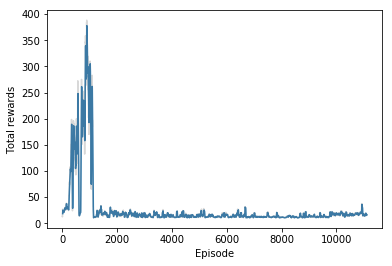

In [187]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Average losses')

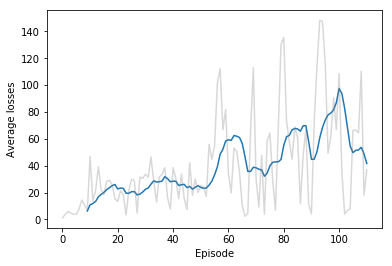

In [183]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [184]:
import gym

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model-seq.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    initial_state = sess.run(model.initial_state) # Qs or current batch or states[:-1]
    state = env.reset()
    total_reward = 0
    while True:
        env.render()
        action_logits, initial_state = sess.run([model.actions_logits, model.final_state],
                                                feed_dict = {model.states: state.reshape([1, -1]), 
                                                             model.initial_state: initial_state})
        action = np.argmax(action_logits)
        state, reward, done, _ = env.step(action)
        total_reward += reward
        if done:
            break
print('total_reward:{}'.format(total_reward))
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward:120.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.